# AKR- run2980

### Empty run, no kripton

what is the S1 distribution?

In [1]:
import time

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [7]:
import Core.system_of_units as units
import tables
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [8]:
from Database import loadDB

In [9]:
import ICython.Sierpe.cBLR as cblr

In [10]:
from scipy import signal

In [55]:
%load_ext Cython

In [11]:
#%matplotlib notebook

In [12]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

06/12/2016
21:28:35


### Access to LSC

### Script DAQ to h5

### Plotting functions

In [13]:
def SetPlotLabels(xlabel="", ylabel="", grid=True):
    """
    Short cut to set labels in plots
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if grid is True:
        plt.grid(which="both", axis="both")


In [14]:
def plot_signal(signal_t, signal, title="signal",
                signal_start=0, signal_end=1e+4, ymax = 200, units=""):
    """
    Given a series signal (t, signal), plot the signal
    """

    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([0, ymax])
    SetPlotLabels(xlabel="t (ns)", ylabel="signal (%s)" % units)
    plt.title(title)
    plt.plot(signal_t, signal)
    plt.show()

### Peak finding, rebinning and ZS functions

In [15]:
def pmt_sum(CWF,adc_to_pes):
    """
    input: pmt data vector, calibration constants
    returns: calibrated sum for pmts
    """
    NPMT = len(CWF)
    NWF = len(CWF[0])
    csum = np.zeros(NWF, dtype=np.float)
    for j in range(NPMT):
        csum += CWF[j, :]*1./adc_to_pes[j]
    return csum



In [76]:
%%cython
cimport numpy as np
import numpy as np
cpdef cpmt_sum(double [:, :] CWF, double [:] adc_to_pes):
    """
    input: pmt data vector, calibration constants
    returns: calibrated sum for pmts
    """
    cdef int NPMT = CWF.shape[0]
    cdef NWF = len(CWF[0])
    cdef double [:] csum = np.zeros(NWF, dtype=np.double)
    cdef int j, k
    
    for j in range(NPMT):
        for k in range(NWF):
            csum[k] += CWF[j, k]*1./adc_to_pes[j]
    return csum



In [89]:
%%cython
cimport numpy as np
import numpy as np
from scipy import signal

cpdef calibrated_pmt_sum(double [:, :] CWF,  
                         double [:] adc_to_pes, 
                         int n_MAU=200,
                         double thr_MAU=5):
    """
    kriptonize computes the ZS calibrated sum of the PMTs after correcting the baseline
    with a MAU to suppress low frequency noise.
    
    """
    
    cdef int j, k
    cdef int NPMT = CWF.shape[0]
    cdef int NWF = CWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),dtype=np.double)*(1./float(n_MAU))
      
   
    # CWF if above MAU threshold
    cdef double [:, :] pmt_thr = np.zeros((NPMT,NWF), dtype=np.double)
    cdef double [:] csum = np.zeros(NWF, dtype=np.double)
    cdef double [:] MAU_pmt = np.zeros(NWF, dtype=np.double)
    
    for j in range(NPMT):
        # MAU for each of the PMTs, following the waveform   
        MAU_pmt = signal.lfilter(MAU,1,CWF[j,:])
        
        for k in range(NWF):
            if CWF[j,k] > MAU_pmt[k] + thr_MAU:
                pmt_thr[j,k] = CWF[j,k]
   
    for j in range(NPMT):
        for k in range(NWF):
            csum[k] += CWF[j, k]*1./adc_to_pes[j]
    return csum

In [16]:
def wfdf(time, energy_pes):
    """
    input: time, energy vectors: 
    returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time
    swf['ene_pes'] = energy_pes 
    return pd.DataFrame(swf)

In [17]:
def wf_thr(wf,threshold=0):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

In [18]:
def find_peaks(wfzs, stride=4, lmin=8):
    """
    Find peaks.
    input: a zero supressed wf
    returns a list of waveform data frames
    do not interrupt the peak if next sample comes within stride
    accept the peak only if larger than lmin samples
    """
    T = wfzs['time_mus'].values
    P = wfzs['ene_pes'].values
    I = wfzs.index.values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(wfzs)) :
        if wfzs.index[i]-stride > wfzs.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        if len(S12[i]) > lmin:
            S12L.append(pd.DataFrame(S12[i], columns=['time_mus','ene_pes','index']))
    return S12L

In [19]:
def find_S12(wfzs, tmin=0*units.mus, tmax=1200*units.mus, stride=4, lmin=8, lmax=1e+6):
    """
    Find S1/S2 peaks.
    input: a zero supressed wf
    returns a list of waveform data frames
    do not interrupt the peak if next sample comes within stride
    accept the peak only if within [lmin, lmax)
    accept the peak only if within [tmin, tmax)
    """
    
    T = wfzs['time_ns'].values
    P = wfzs['ene_pes'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0]])
    
    for i in range(1,len(wfzs)) :
        
        if T[i] > tmax: 
            break
        
        if T[i] < tmin:
            continue
            
        if wfzs.index[i] - stride > wfzs.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i]])
        else:
            S12[j].append([T[i],P[i]])
            
    S12L=[]
    for i in S12.keys():
        if len(S12[i]) >= lmin and len(S12[i]) < lmax:
            S12L.append(pd.DataFrame(S12[i], columns=['time_ns','ene_pes']))
    return S12L

In [20]:
def scan_S12(S12):
    """
    prints and plots the peaks of input list S12
    """
    print('number of peaks = {}'.format(len(S12)))
    for i,s in enumerate(S12):
        print('S12 number = {}, samples = {} sum in pes ={}'.format(i, len(s), np.sum(s.ene_pes.values)))
        plt.plot(s.time_ns.values,s.ene_pes)
        plt.show()
        raw_input('hit return')

In [21]:
def kriptonize(pmtcwf, MAU, adc_to_pes, 
               thr_MAU=1*units.adc, thr_s12=0.5*units.pes, 
               event=0, plot=True):
    """
    kriptonize computes the ZS calibrated sum of the PMTs after correcting the baseline
    with a MAU to suppress low frequency noise.
    
    input: 
    1) Corrected waveform
    2) A MAU used to supress low frequency noise
    3) calibration constants adc_to_pes
    
    parameters:
    treshold to select signal above MAU (in pes)
    threshold to keep signal sample
    
    returns:
    calibrated sum of pmts
    ZS waveform for calibrated sum
    """
    
    # corrected signal in each of the PMTs
    signal_pmt = pmtcwf[event, :, :].astype(float)
    NPMT = signal_pmt.shape[0]
    
    if plot:
        mpl.plot_waveforms(signal_pmt)
        plt.show()
        raw_input('corrected waveform. Return to continue')
    
    # MAU for each of the PMTs, following the waveform
    MAU_pmt = np.array([signal.lfilter(MAU,1,signal_pmt[i,:]) for i in range(NPMT)])
    
    if plot:
        mpl.plot_waveforms(MAU_pmt)
        plt.show()
        raw_input('MAU. Return to continue')
    
    # signal for each of the PMTs, only if above MAU + thr_MAU for each sample
    pmt_thr = np.array([(signal_pmt[i,:] >(MAU_pmt[i,:] + thr_MAU)) * signal_pmt[i,:] for i in range(NPMT)])
    
    if plot:
        mpl.plot_waveforms(pmt_thr)
        plt.show()
        raw_input('pmt_thr. Return to continue')
    
    # calibrated sum of PMTs (in PES)
    csum = pmt_sum(pmt_thr,adc_to_pes)
    
    if plot:
        plt.plot(signal_t,csum)
        plt.show()
        raw_input('pmt_sum. Return to continue')
    
    # DataFrame for calibrated sum
    swf = wfdf(signal_t,csum)
    
    # Supress samples below threshold (in pes)
    wfzs = wf_thr(swf,threshold=thr_s12)
    
    return csum, wfzs

In [46]:
def kriptonize2(CWF, MAU, adc_to_pes, 
               thr_MAU=1*units.adc, thr_s12=0.5*units.pes, 
               plot=False):
    """
    kriptonize computes the ZS calibrated sum of the PMTs after correcting the baseline
    with a MAU to suppress low frequency noise.
    
    input: 
    1) Corrected waveform
    2) A MAU used to supress low frequency noise
    3) calibration constants adc_to_pes
    
    parameters:
    treshold to select signal above MAU (in pes)
    threshold to keep signal sample
    
    returns:
    calibrated sum of pmts
    ZS waveform for calibrated sum
    """
    
    # corrected signal in each of the PMTs
    signal_pmt = CWF
    NPMT = signal_pmt.shape[0]
    
    if plot:
        mpl.plot_waveforms(signal_pmt)
        plt.show()
        raw_input('corrected waveform. Return to continue')
    
    # MAU for each of the PMTs, following the waveform
    MAU_pmt = np.array([signal.lfilter(MAU,1,signal_pmt[i,:]) for i in range(NPMT)])
    
    if plot:
        mpl.plot_waveforms(MAU_pmt)
        plt.show()
        raw_input('MAU. Return to continue')
    
    # signal for each of the PMTs, only if above MAU + thr_MAU for each sample
    pmt_thr = np.array([(signal_pmt[i,:] >(MAU_pmt[i,:] + thr_MAU)) * signal_pmt[i,:] for i in range(NPMT)])
    
    if plot:
        mpl.plot_waveforms(pmt_thr)
        plt.show()
        raw_input('pmt_thr. Return to continue')
    
    # calibrated sum of PMTs (in PES)
    csum = pmt_sum(pmt_thr,adc_to_pes)
    
    if plot:
        plt.plot(signal_t,csum)
        plt.show()
        raw_input('pmt_sum. Return to continue')
    
    # DataFrame for calibrated sum
    swf = wfdf(signal_t,csum)
    
    # Supress samples below threshold (in pes)
    wfzs = wf_thr(swf,threshold=thr_s12)
    
    return csum, wfzs

In [28]:
def deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=0):
    """
    Deconvolution of all the PMTs in the event cython function
    """
    NPMT = pmtrwf.shape[1]
    CWF = []
    
    for pmt in range(NPMT):
       
        signal_r, acum, baseline, baseline_end, noise_rms = cblr.deconvolve_signal_acum(pmtrwf[event,pmt],
                                                                                  n_baseline=n_baseline,
                                                                                  coef_clean=DataPMT.coeff_c[pmt],
                                                                                  coef_blr=DataPMT.coeff_blr[pmt],
                                                                                  thr_trigger=thr_trigger,
                                                                                  acum_discharge_length = 5000)
        CWF.append(signal_r)
            
        
    return np.array(CWF)

### Run 2976

In [22]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976

run_2976.gdc1next.000.next1el_2976.root.h5
run_2976.gdc1next.001.next1el_2976.root.h5
run_2976.gdc1next.002.next1el_2976.root.h5
run_2976.gdc1next.003.next1el_2976.root.h5
run_2976.gdc1next.004.next1el_2976.root.h5
run_2976.gdc1next.005.next1el_2976.root.h5


In [23]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'

In [24]:
ffile = 'run_2976.gdc1next.000.next1el_2976.root.h5'

In [25]:
r2976 = tables.open_file(path+ffile,'r+')

In [30]:
pmtrwf = r2976.root.RD.pmtrwf

In [31]:
DataPMT = loadDB.DataPMT(2980)

In [32]:
adc_to_pes = abs(DataPMT.adc_to_pes.values)

In [38]:
MAU_n=200
MAU = np.array(np.ones(MAU_n),dtype=float)*(1./float(MAU_n))
signal_t = np.arange(0., 48000*25, 25)

In [ ]:
input_files =['run_2976.gdc1next.000.next1el_2976.root.h5',
              'run_2976.gdc1next.001.next1el_2976.root.h5',
              'run_2976.gdc1next.002.next1el_2976.root.h5',
              'run_2976.gdc1next.003.next1el_2976.root.h5',
              'run_2976.gdc1next.004.next1el_2976.root.h5',
              'run_2976.gdc1next.005.next1el_2976.root.h5']

In [57]:
CWF = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=0)

In [70]:
CWF.astype(np.double).dtype

dtype('float64')

In [72]:
DCWF = CWF.astype(np.double)

In [77]:
cpmt = cpmt_sum(DCWF, adc_to_pes)

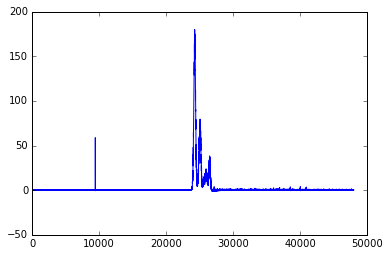

In [78]:
plt.plot(cpmt)

In [80]:
MAU = np.array(np.ones(200),dtype=np.double)*(1./float(200))

In [81]:
def calibrated_pmt_sum(CWF, MAU, adc_to_pes, thr_MAU=1*units.adc, thr_s12=0.5*units.pes):
    """
    kriptonize computes the ZS calibrated sum of the PMTs after correcting the baseline
    with a MAU to suppress low frequency noise.
    
    input: 
    1) Corrected waveform
    2) A MAU used to supress low frequency noise
    3) calibration constants adc_to_pes
    
    parameters:
    treshold to select signal above MAU (in pes)
    threshold to keep signal sample
    
    returns:
    calibrated sum of pmts
    ZS waveform for calibrated sum
    """
    
    # corrected signal in each of the PMTs
    signal_pmt = CWF.astype(np.double)
    NPMT = signal_pmt.shape[0]
      
    # MAU for each of the PMTs, following the waveform
    MAU_pmt = np.array([signal.lfilter(MAU,1,signal_pmt[i,:]) for i in range(NPMT)], dtype=np.double)
   
    # signal for each of the PMTs, only if above MAU + thr_MAU for each sample
    pmt_thr = np.array([(signal_pmt[i,:] >(MAU_pmt[i,:] + thr_MAU)) * signal_pmt[i,:] \
                        for i in range(NPMT)], dtype=np.double)
    
    
    # calibrated sum of PMTs (in PES)
    csum = pmt_sum(pmt_thr,adc_to_pes)
    
    
    return csum

In [82]:
cpmt2 = calibrated_pmt_sum(CWF, MAU, adc_to_pes, thr_MAU=1*units.adc, thr_s12=0.5*units.pes)

In [90]:
casum = calibrated_pmt_sum(DCWF,  adc_to_pes, n_MAU=200, thr_MAU=5)

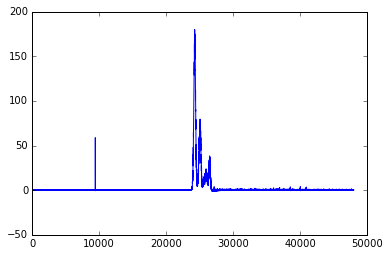

In [91]:
plt.plot(casum)

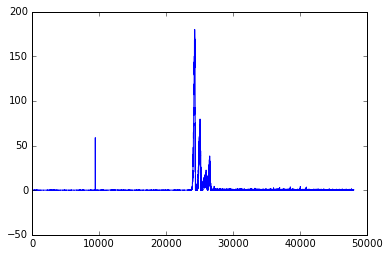

In [83]:
plt.plot(cpmt2)

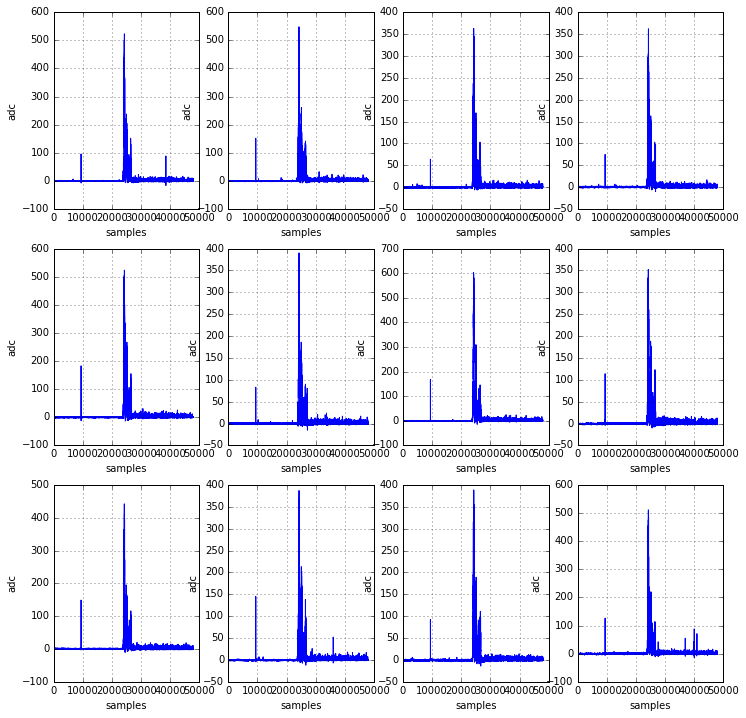

corrected waveform. Return to continue


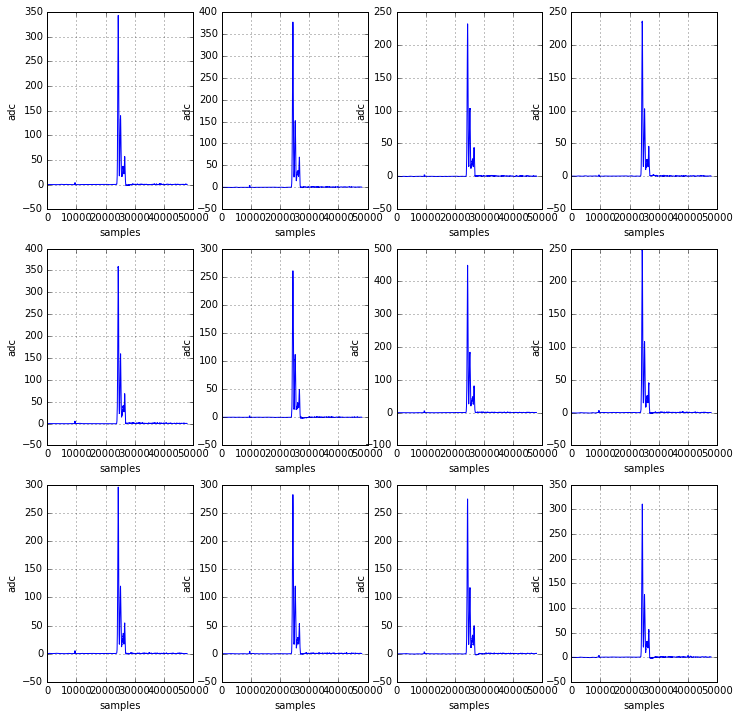

MAU. Return to continue


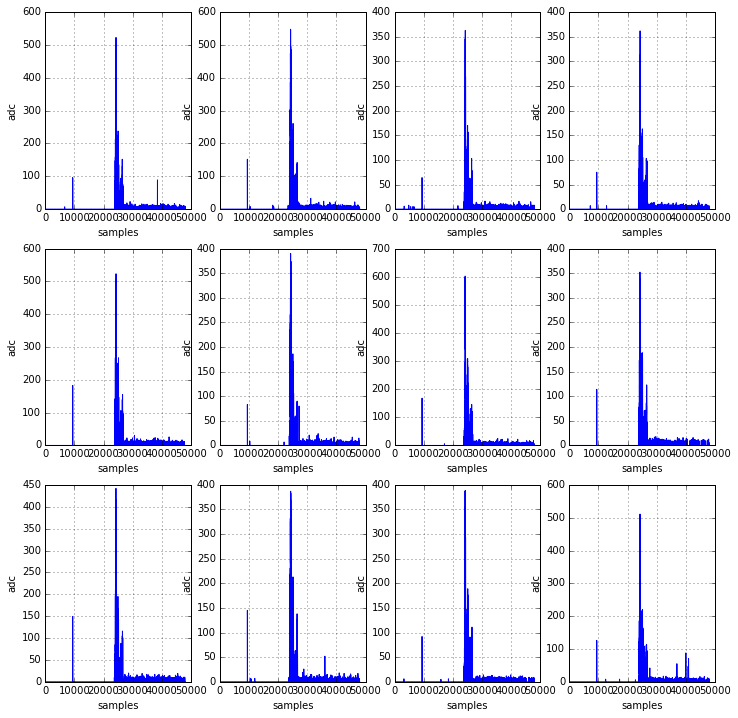

pmt_thr. Return to continue


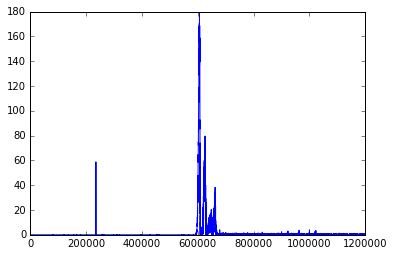

pmt_sum. Return to continue


In [39]:
csum, wfzs = kriptonize2(CWF, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=0, plot=True)

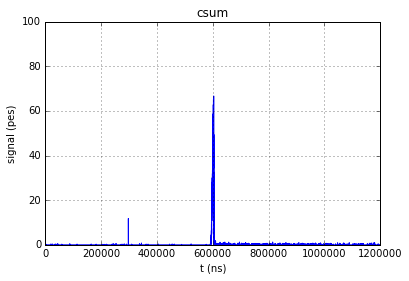

In [41]:
CWF = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=1)
csum, wfzs = kriptonize2(CWF, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=0, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 1
S12 number = 0, samples = 12 sum in pes =52.5630335641


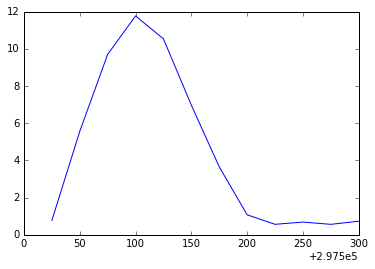

hit return


In [42]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16)
scan_S12(S1)

number of peaks = 1
S12 number = 0, samples = 487 sum in pes =12347.7806061


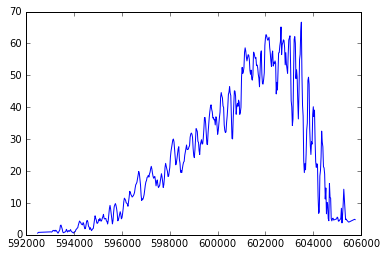

hit return


In [43]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=2000)
scan_S12(S2)

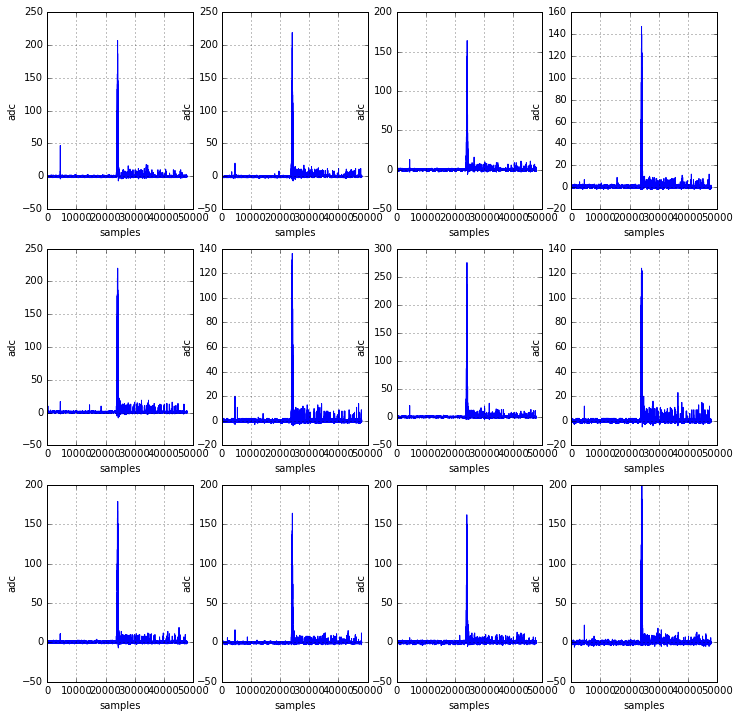

corrected waveform. Return to continue


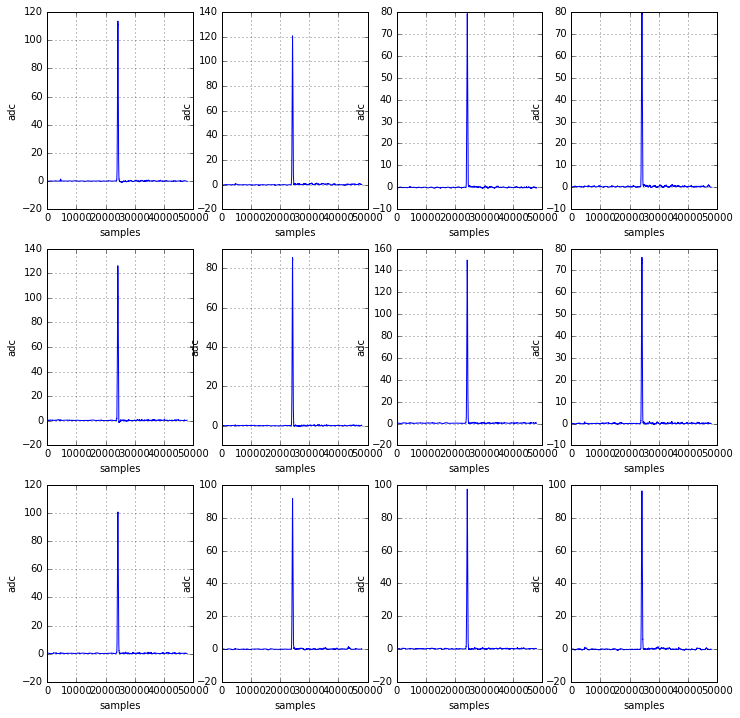

MAU. Return to continue


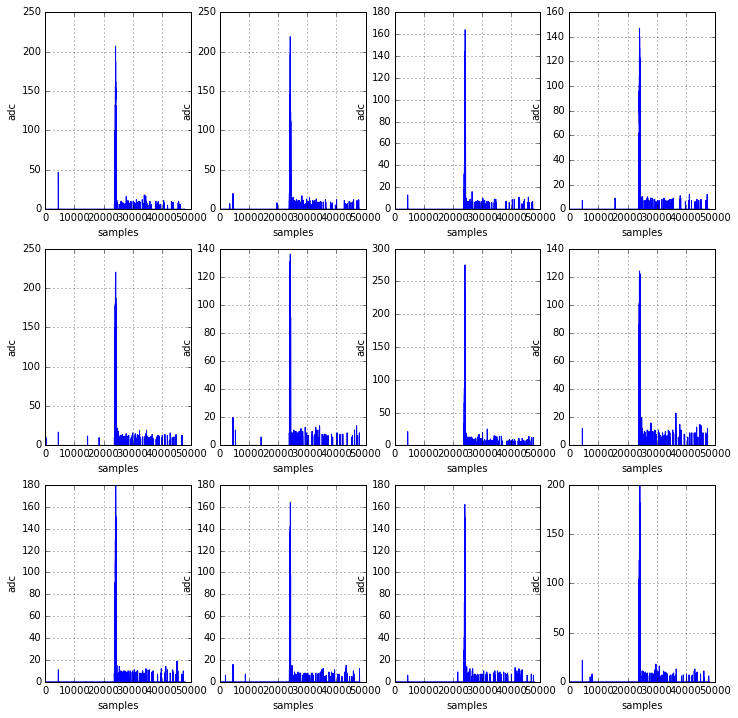

pmt_thr. Return to continue


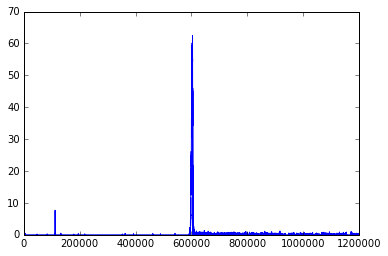

pmt_sum. Return to continue


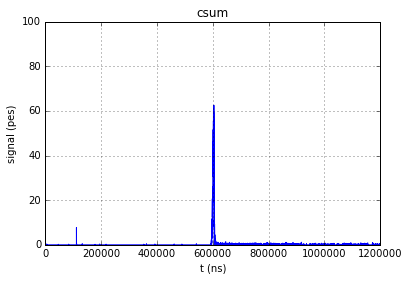

In [44]:
CWF = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=2)
csum, wfzs = kriptonize2(CWF, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 1
S12 number = 0, samples = 14 sum in pes =43.7597663325


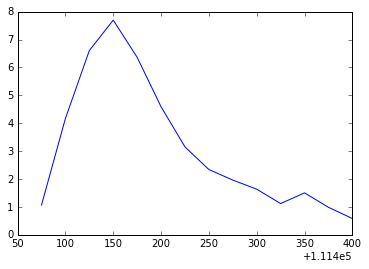

hit return
number of peaks = 1
S12 number = 0, samples = 449 sum in pes =11242.1478993


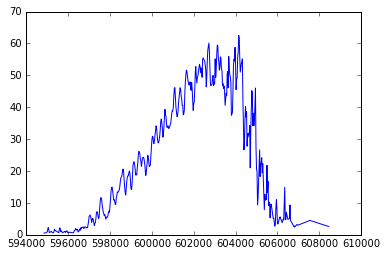

hit return


In [45]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16)
scan_S12(S1)
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=2000)
scan_S12(S2)

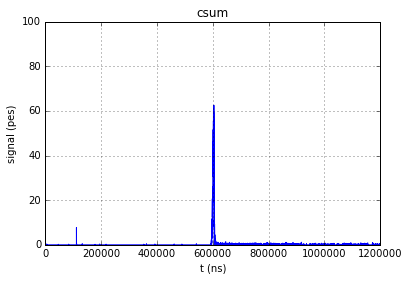

In [47]:
CWF = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=2)
csum, wfzs = kriptonize2(CWF, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 1
S12 number = 0, samples = 14 sum in pes =43.7597663325


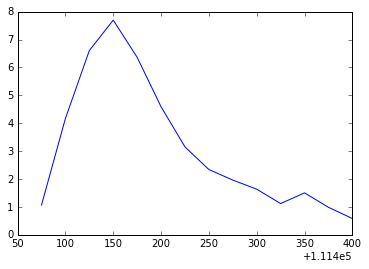

hit return
number of peaks = 1
S12 number = 0, samples = 449 sum in pes =11242.1478993


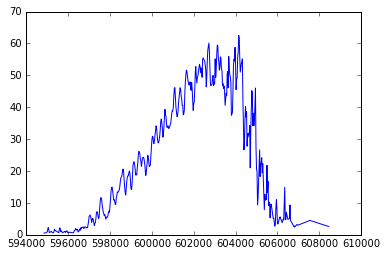

hit return


In [48]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16)
scan_S12(S1)
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=2000)
scan_S12(S2)

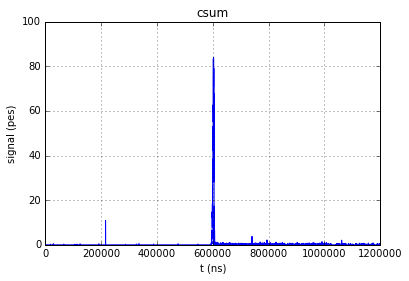

In [49]:
CWF = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=3)
csum, wfzs = kriptonize2(CWF, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 1
S12 number = 0, samples = 12 sum in pes =56.997845589


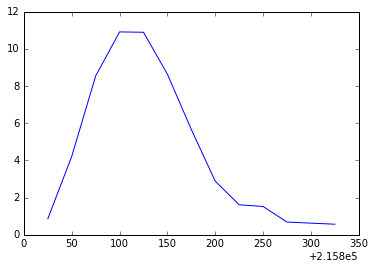

hit return
number of peaks = 1
S12 number = 0, samples = 425 sum in pes =13792.7755788


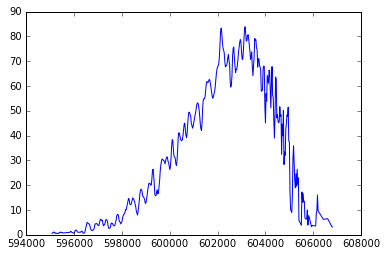

hit return


In [50]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16)
scan_S12(S1)
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=2000)
scan_S12(S2)

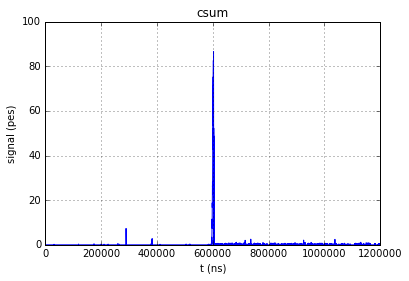

In [52]:
CWF = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=5)
csum, wfzs = kriptonize2(CWF, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 3
S12 number = 0, samples = 10 sum in pes =34.4208858551


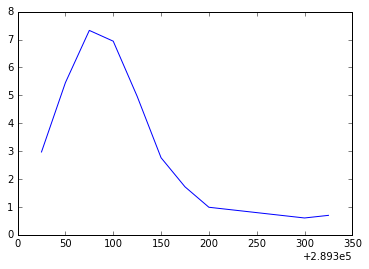

hit return
S12 number = 1, samples = 5 sum in pes =7.74879488219


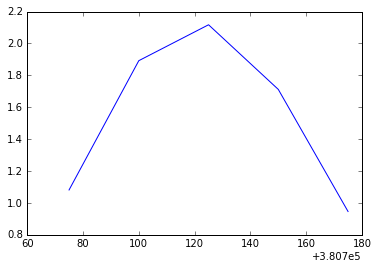

hit return
S12 number = 2, samples = 6 sum in pes =10.6320673965


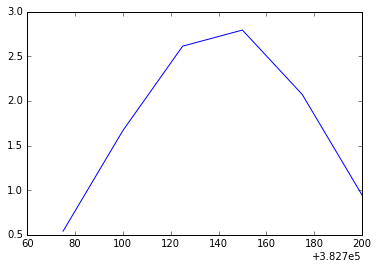

hit return
number of peaks = 1
S12 number = 0, samples = 371 sum in pes =12085.2448423


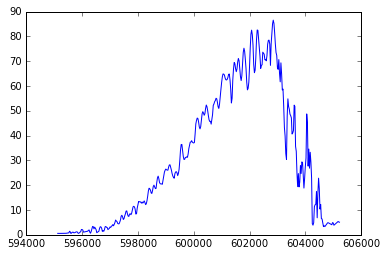

hit return


In [53]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16)
scan_S12(S1)
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=2000)
scan_S12(S2)

In [290]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=16)

In [291]:
len(S1)

0

In [292]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=200)

In [293]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 128 sum in pes =4443.77400438


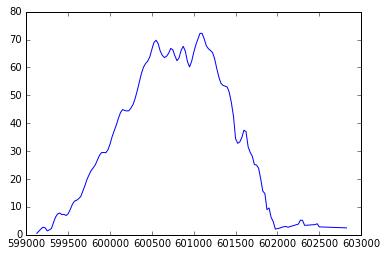

hit return


In [294]:
scan_S12(S2)

number of peaks = 1
S12 number = 0, samples = 127 sum in pes =4441.29619206


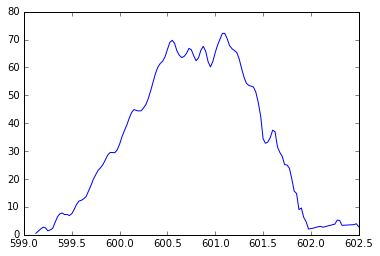

hit return


In [222]:
scan_S12(S12)

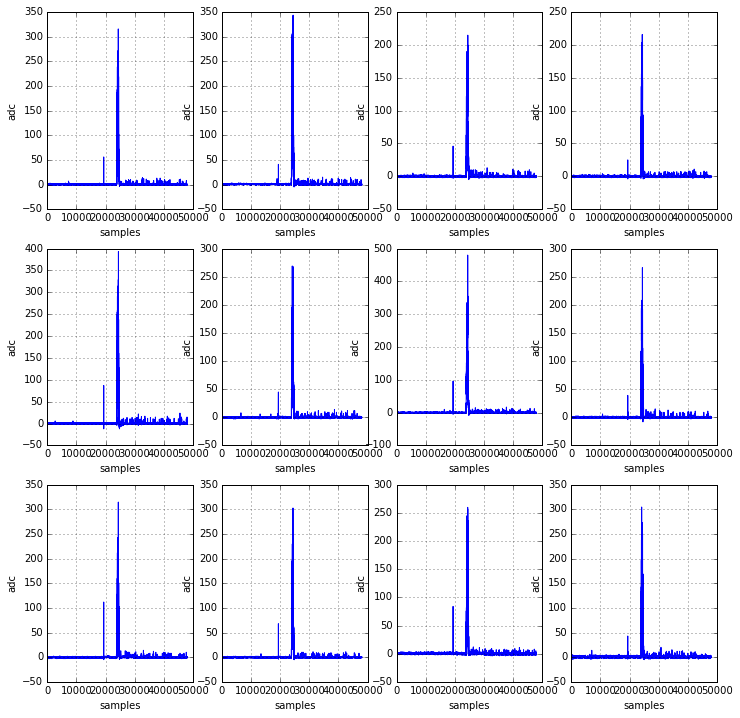

corrected waveform. Return to continue


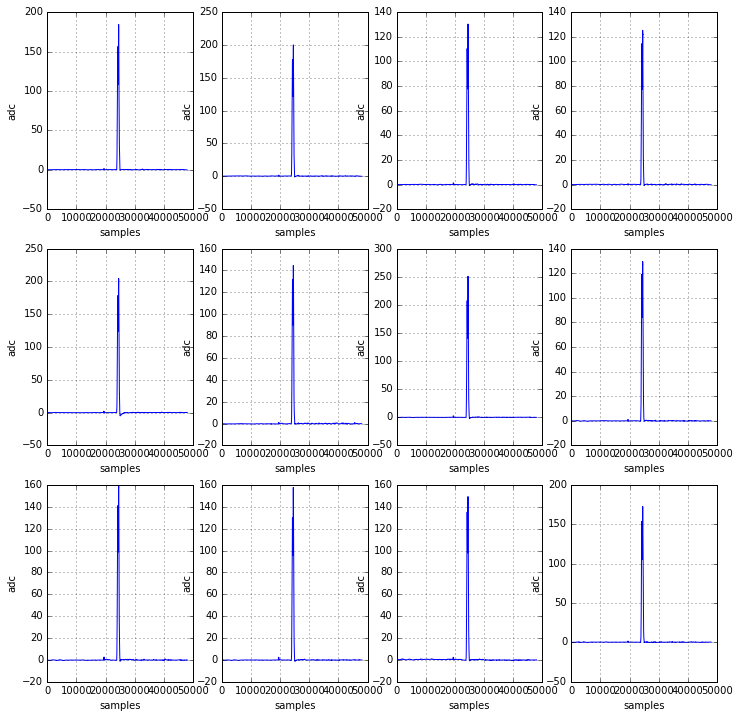

MAU. Return to continue


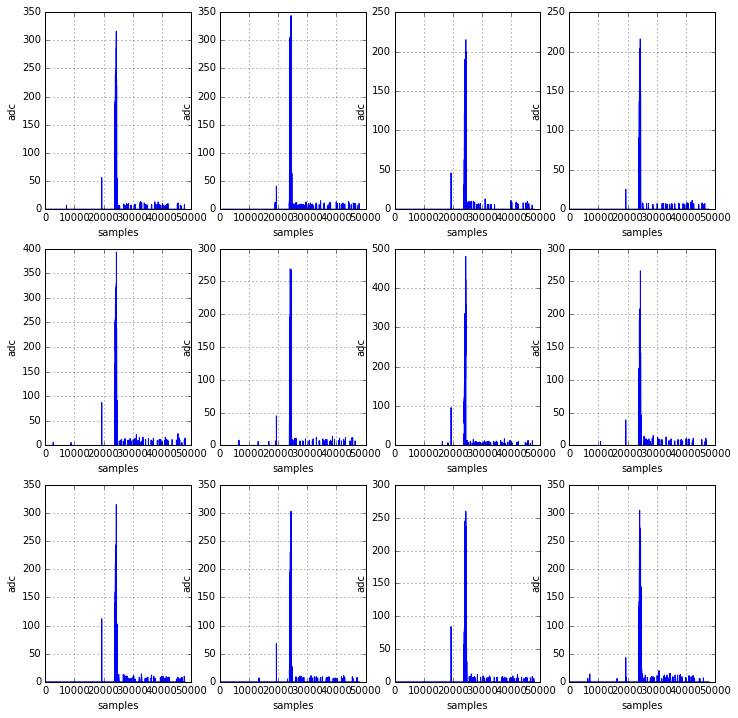

pmt_thr. Return to continue


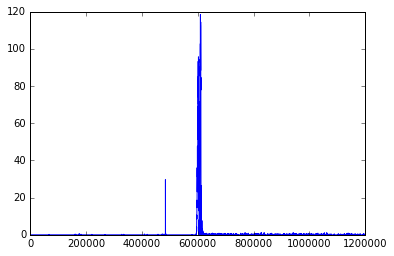

pmt_sum. Return to continue


In [295]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=1, plot=True)

In [298]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [299]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 16 sum in pes =153.190234033


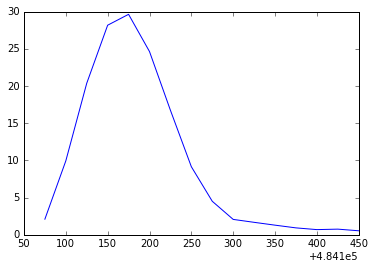

hit return


In [300]:
scan_S12(S1)

In [303]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=690*units.mus, stride=40, lmin=100, lmax=2000)

In [304]:
len(S2)

2

number of peaks = 2
S12 number = 0, samples = 399 sum in pes =16184.5860782


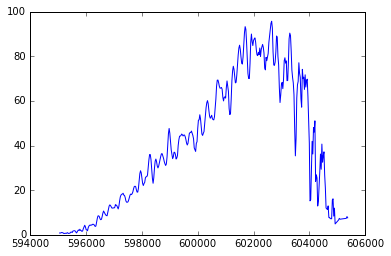

hit return
S12 number = 1, samples = 205 sum in pes =13343.4416957


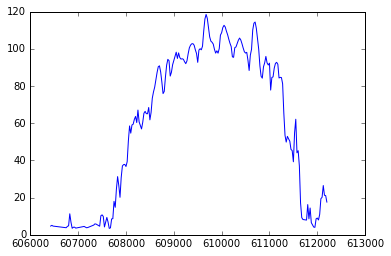

hit return


In [305]:
scan_S12(S2)

#### not true S2

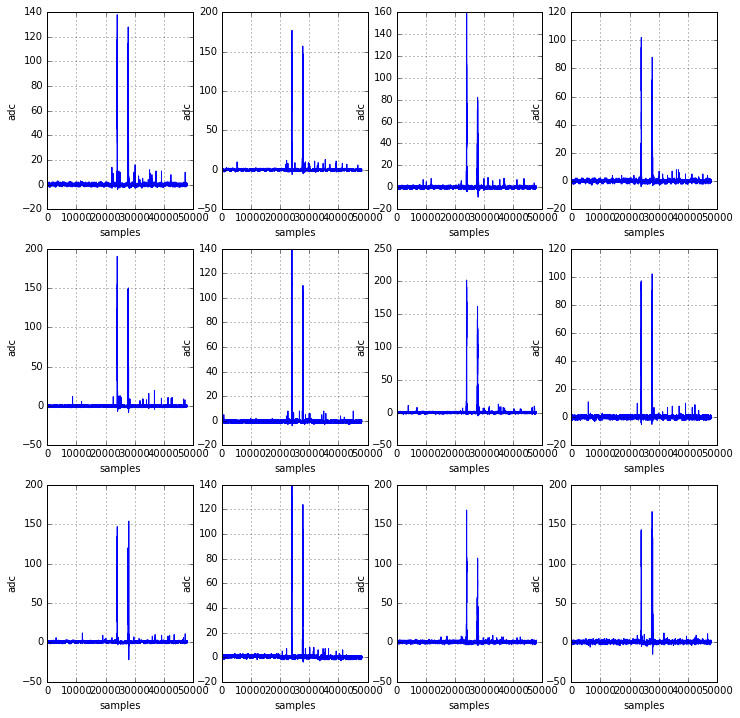

corrected waveform. Return to continue


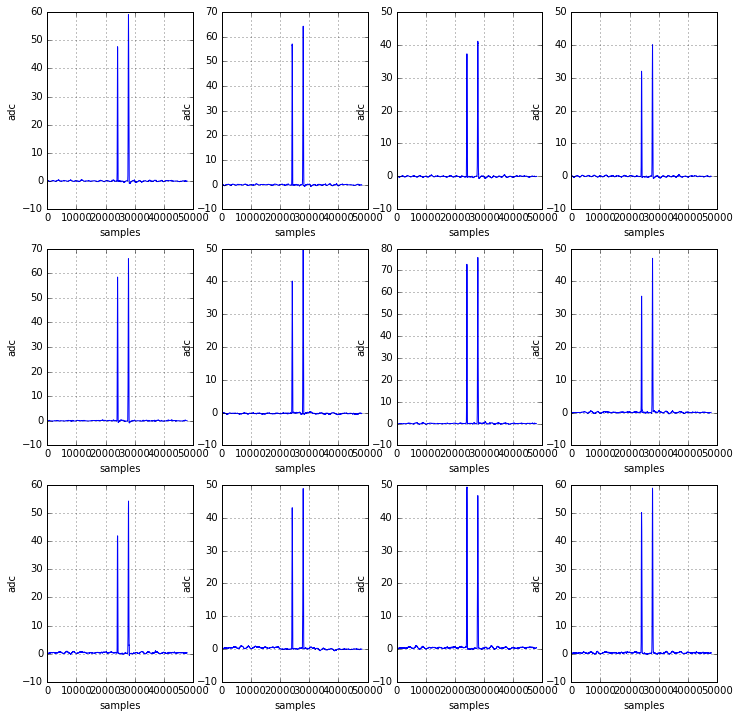

MAU. Return to continue


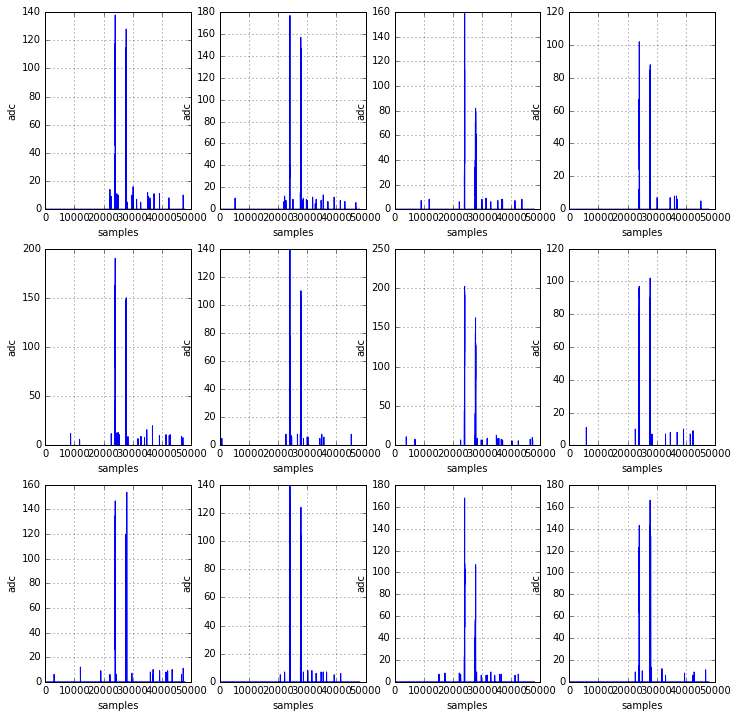

pmt_thr. Return to continue


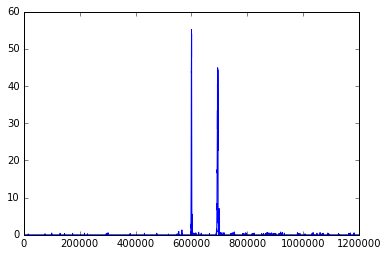

pmt_sum. Return to continue


In [306]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=2, plot=True)

In [307]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [308]:
len(S1)

0

In [309]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=200)

In [310]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 165 sum in pes =4227.90048791


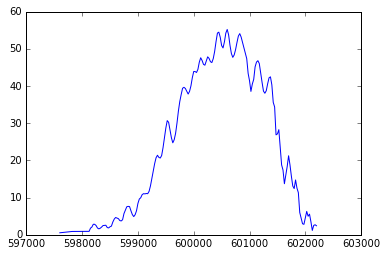

hit return


In [311]:
scan_S12(S2)

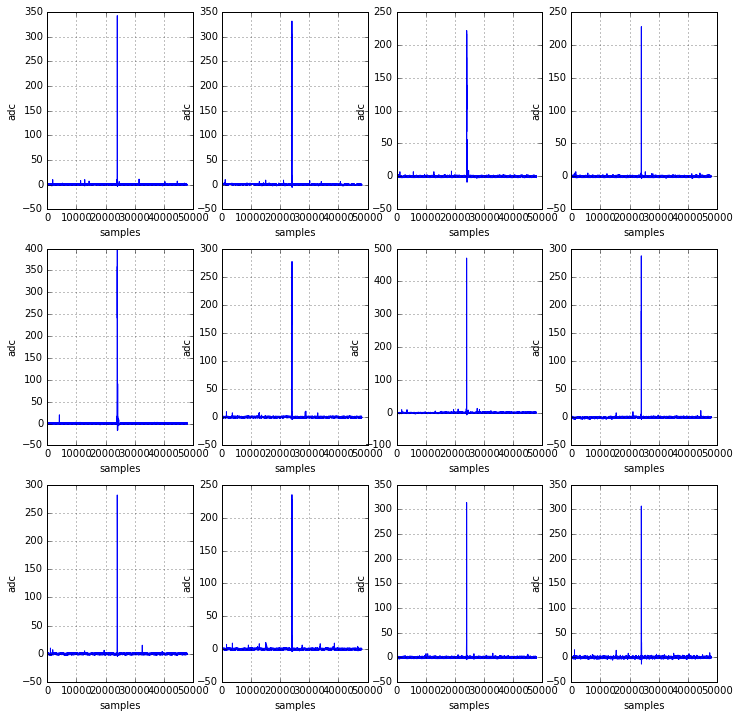

corrected waveform. Return to continue


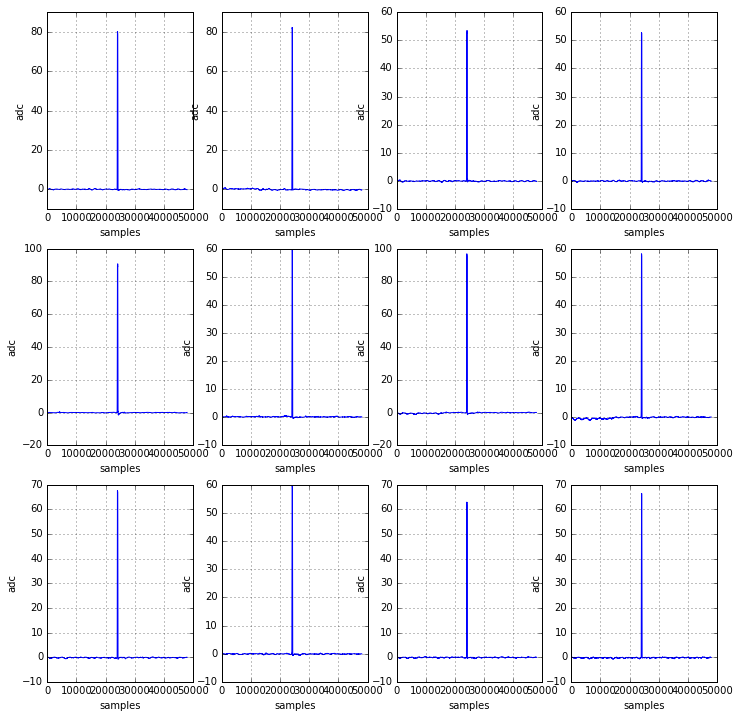

MAU. Return to continue


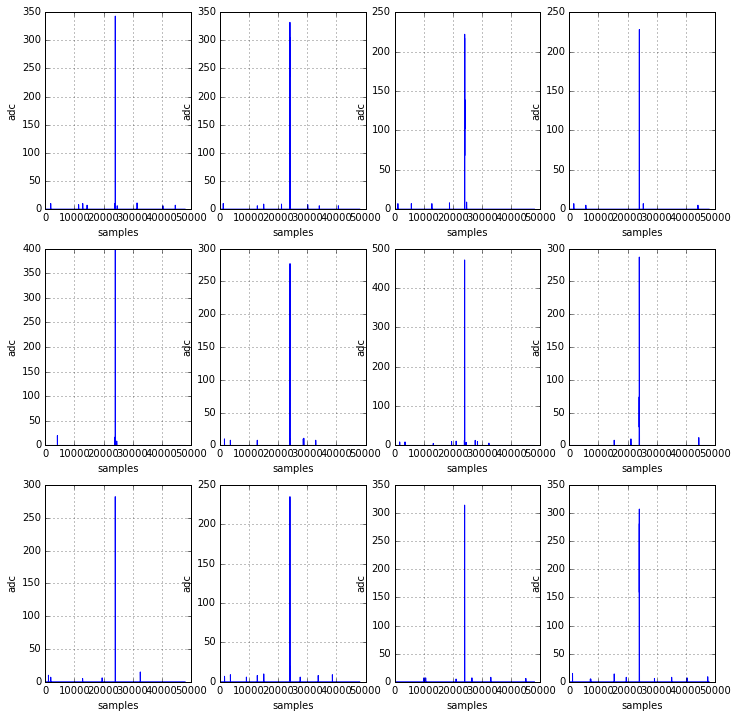

pmt_thr. Return to continue


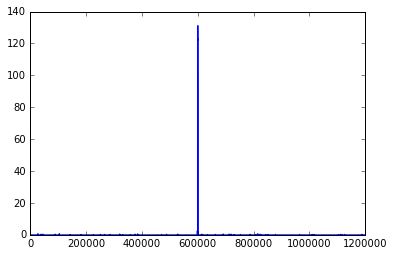

pmt_sum. Return to continue


In [312]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=3, plot=True)

In [313]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [314]:
len(S1)

0

In [321]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=10, lmax=3000)

In [322]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 100 sum in pes =6592.32479299


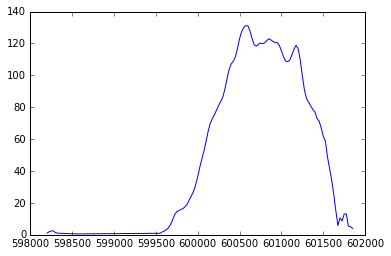

hit return


In [323]:
scan_S12(S2)

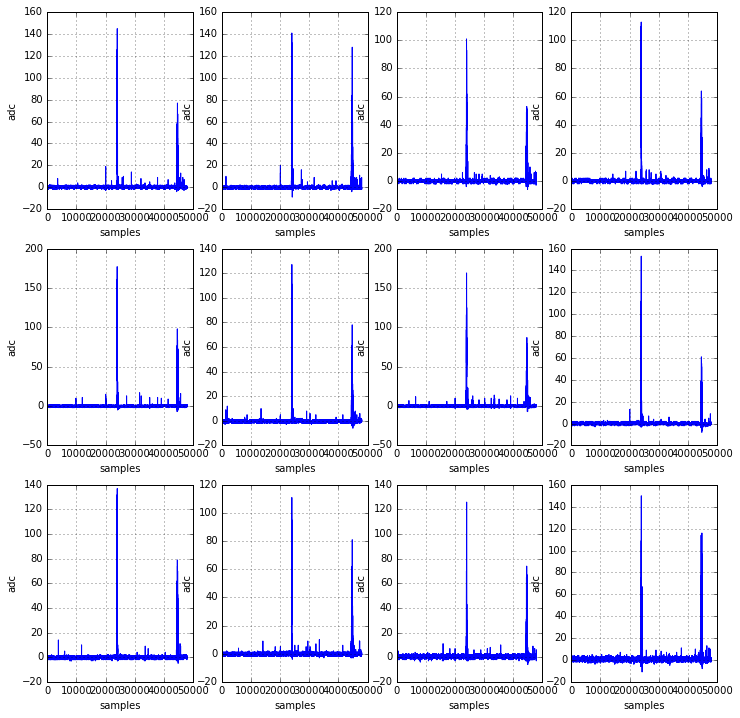

corrected waveform. Return to continue


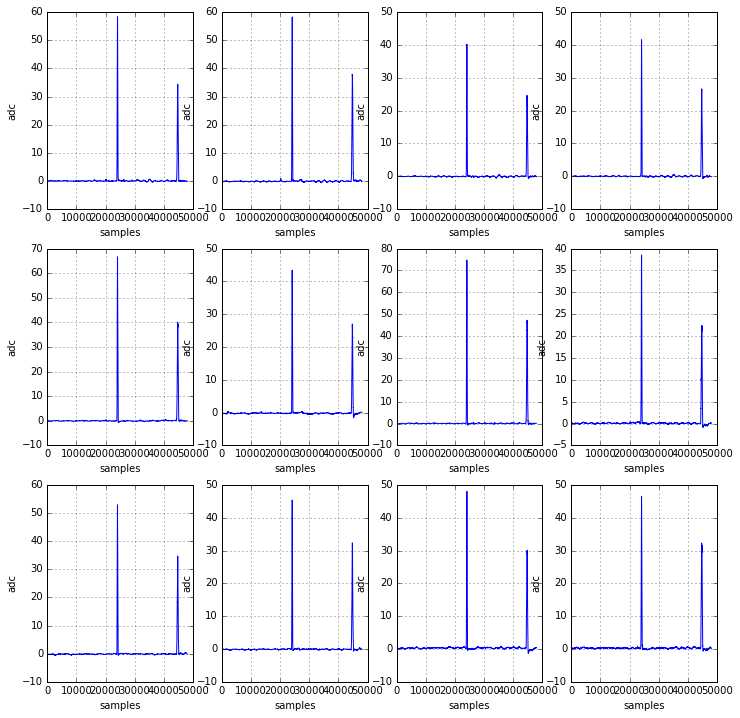

MAU. Return to continue


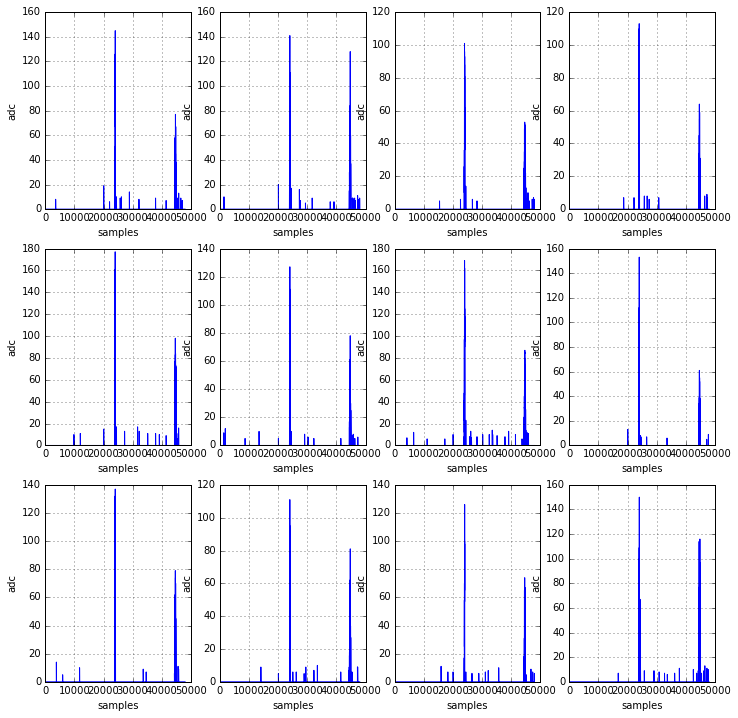

pmt_thr. Return to continue


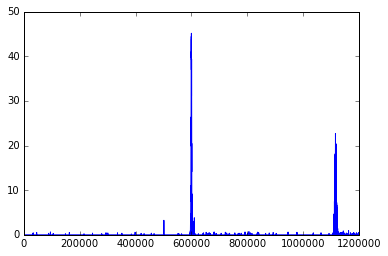

pmt_sum. Return to continue


In [324]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=4, plot=True)

In [325]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [326]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 11 sum in pes =15.3410780245


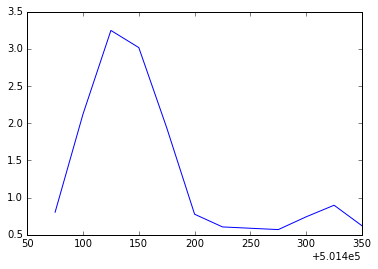

hit return


In [328]:
scan_S12(S1)

In [334]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

In [335]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 223 sum in pes =4473.98192924


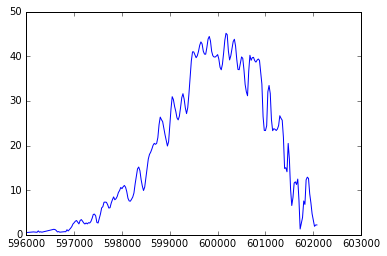

hit return


In [336]:
scan_S12(S2)

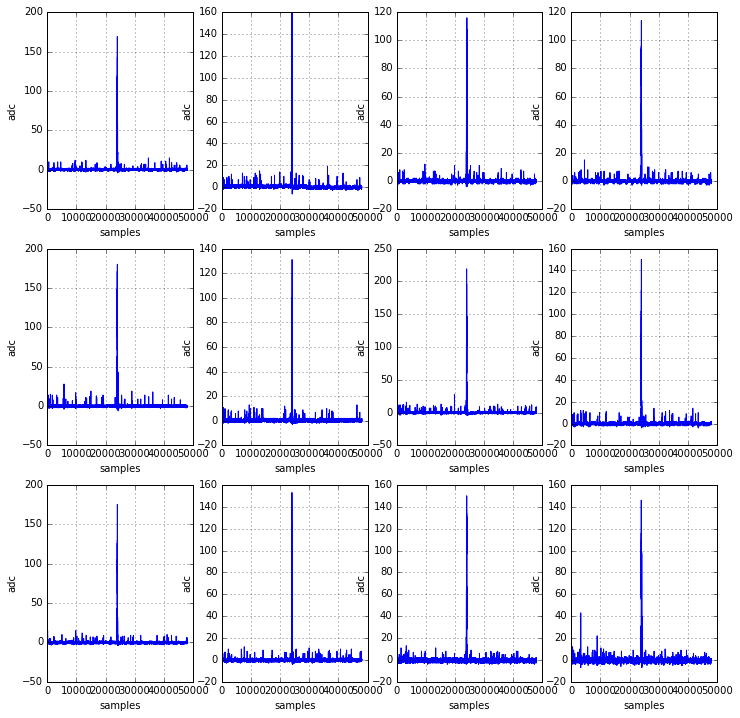

corrected waveform. Return to continue


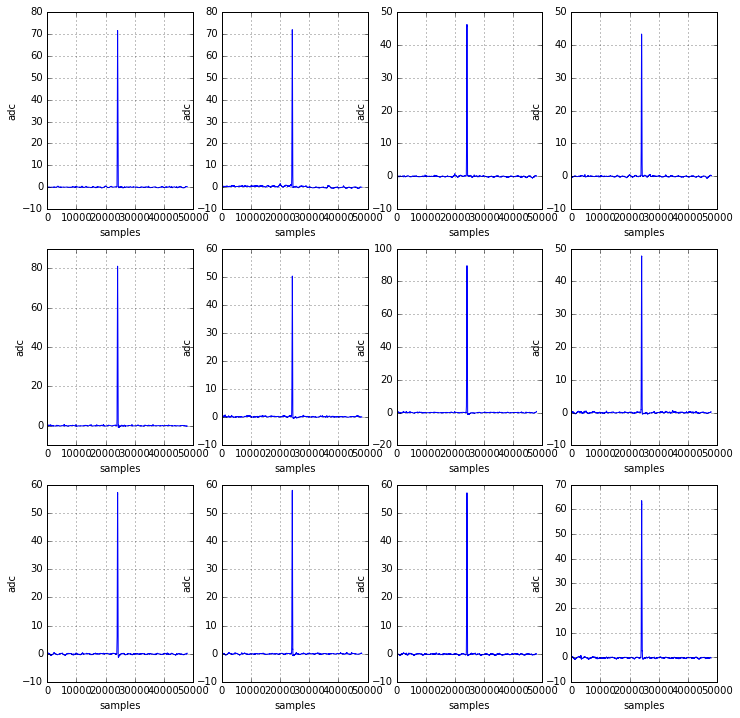

MAU. Return to continue


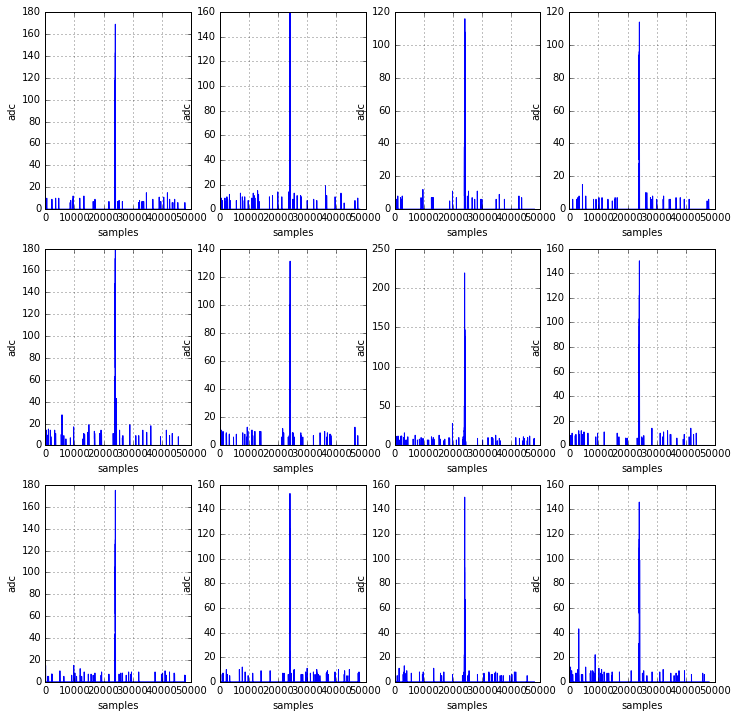

pmt_thr. Return to continue


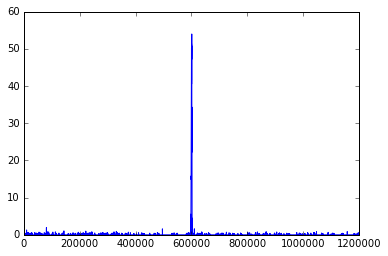

pmt_sum. Return to continue


In [337]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=5, plot=True)

In [338]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [339]:
len(S1)

0

In [340]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

In [341]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 228 sum in pes =5457.45941413


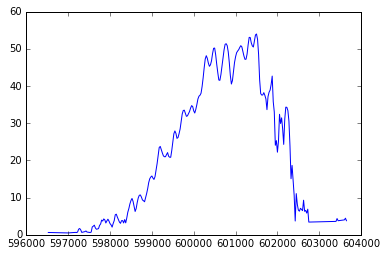

hit return


In [342]:
scan_S12(S2)

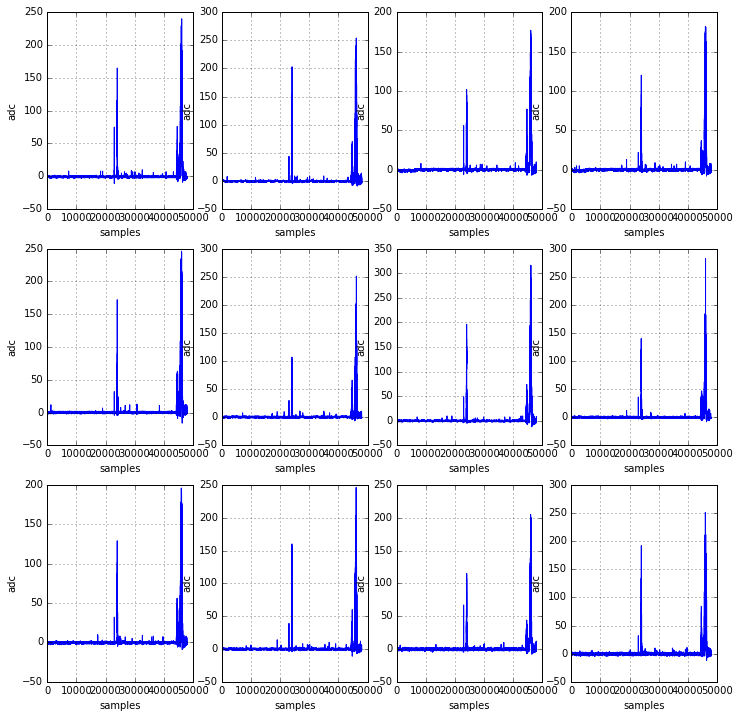

corrected waveform. Return to continue


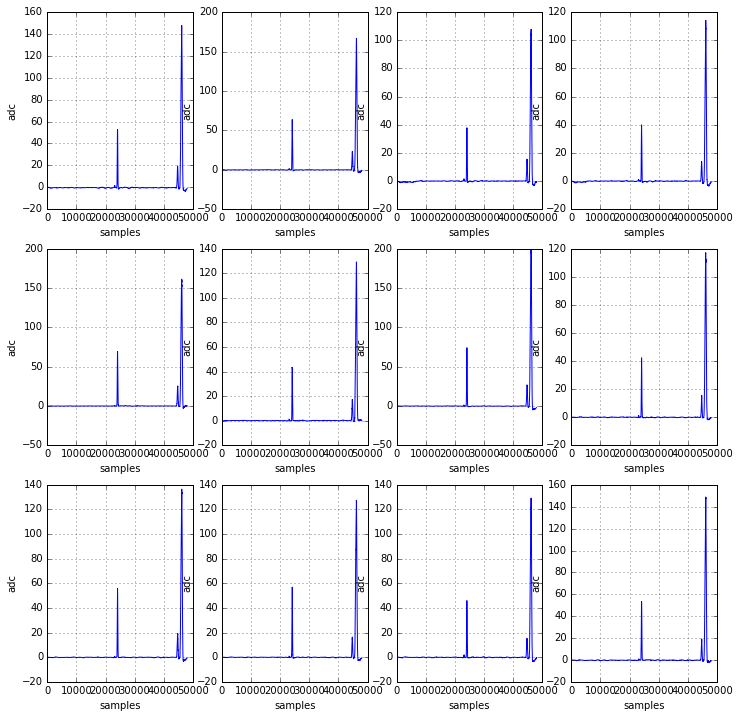

MAU. Return to continue


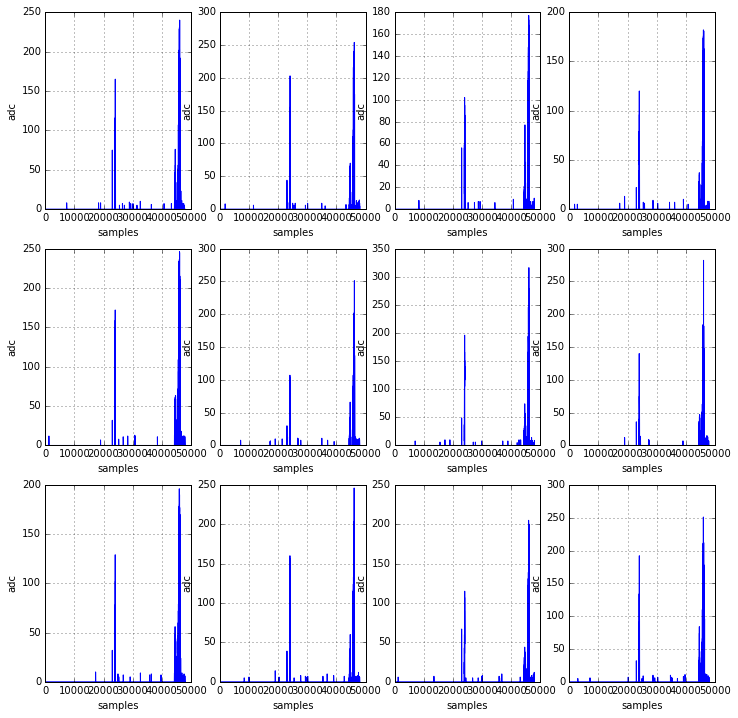

pmt_thr. Return to continue


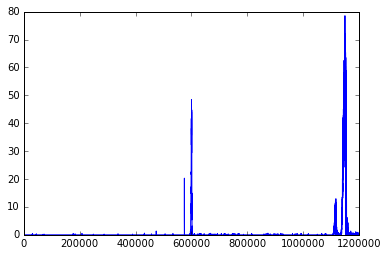

pmt_sum. Return to continue


In [343]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=6, plot=True)

In [344]:
S1 = find_S12(wfzs, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [345]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 15 sum in pes =113.879433016


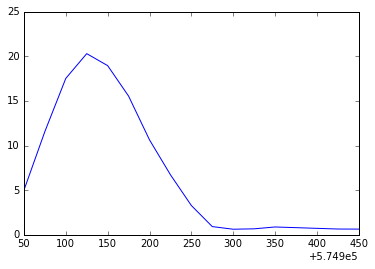

hit return


In [346]:
scan_S12(S1)

In [347]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

In [348]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 235 sum in pes =4624.1527689


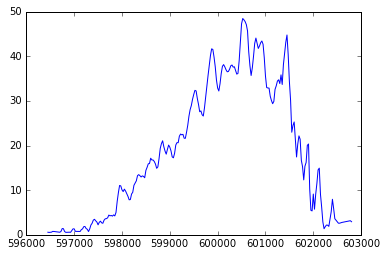

hit return


In [349]:
scan_S12(S2)

#### A very large S1, which implies event should be near cathode. Charge of Kr also suggests that event is near cathode, but distance S1 to S2 is very small.

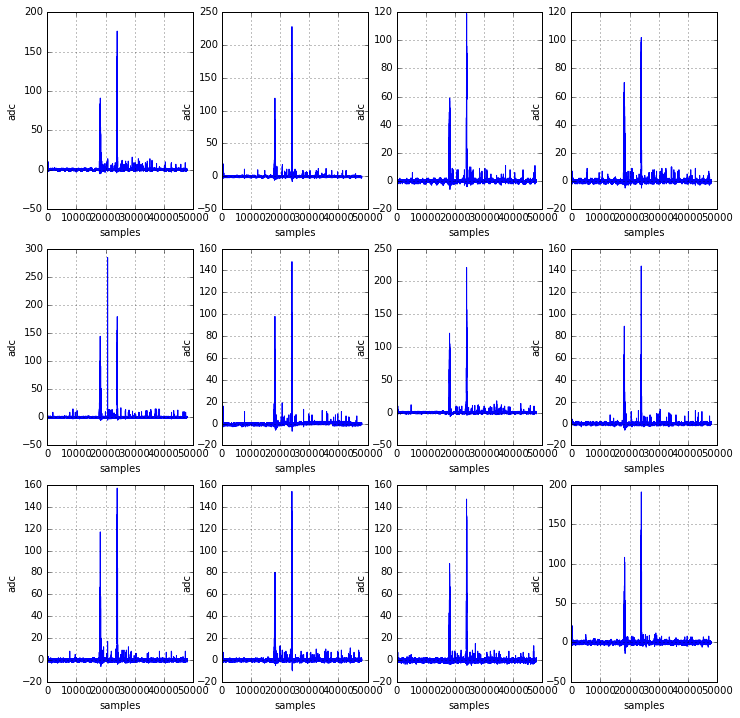

corrected waveform. Return to continue


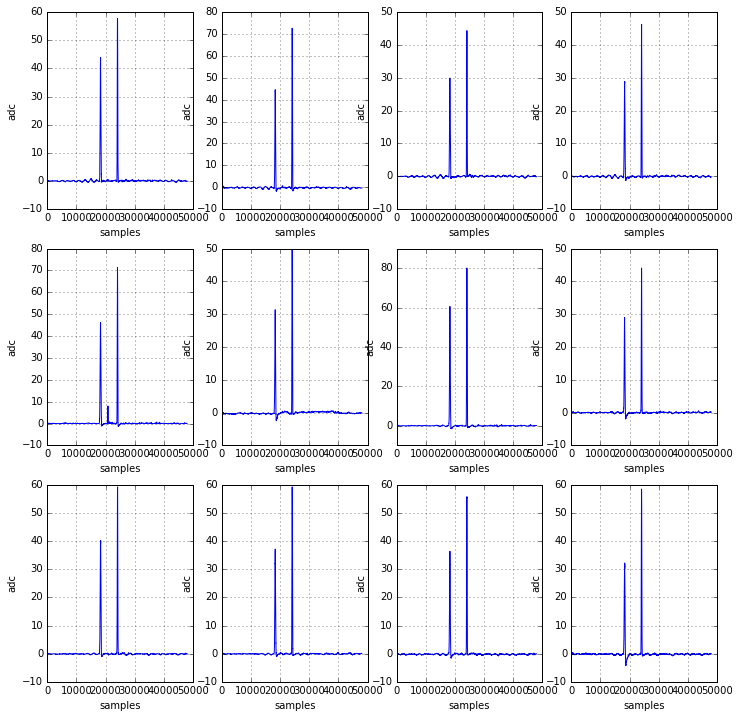

MAU. Return to continue


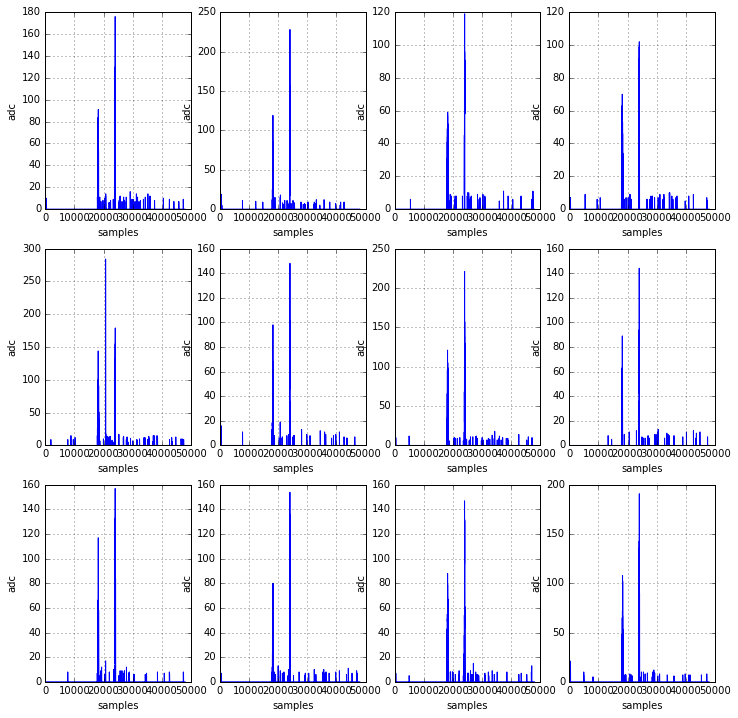

pmt_thr. Return to continue


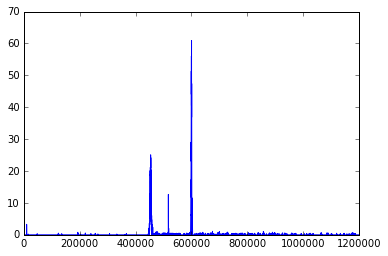

pmt_sum. Return to continue


In [350]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=7, plot=True)

In [351]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [352]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 12 sum in pes =62.496544422


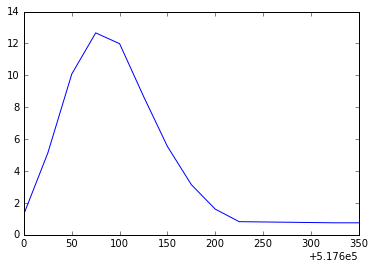

hit return


In [353]:
scan_S12(S1)

In [354]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

In [355]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 219 sum in pes =5106.03228116


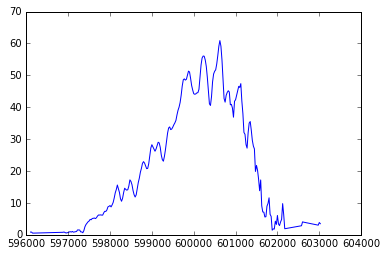

hit return


In [356]:
scan_S12(S2)

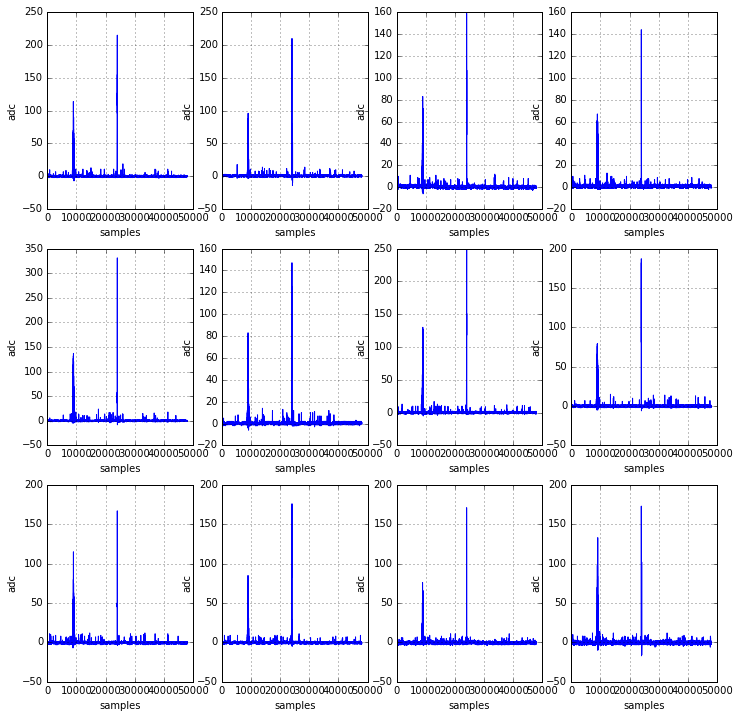

corrected waveform. Return to continue


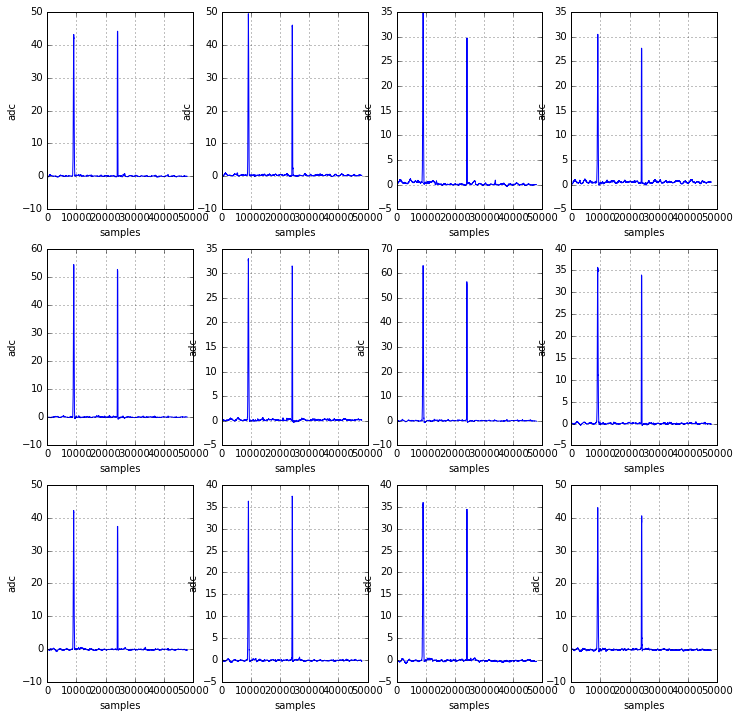

MAU. Return to continue


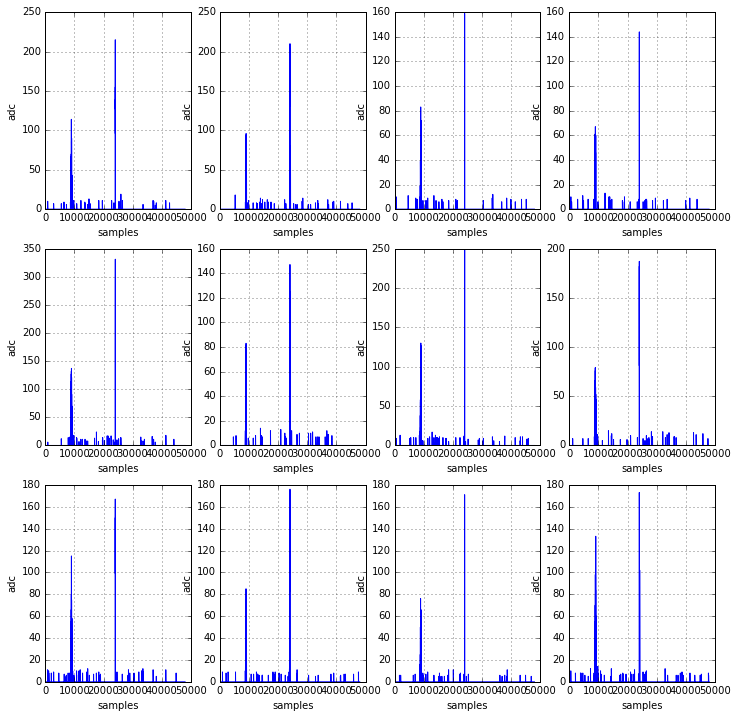

pmt_thr. Return to continue


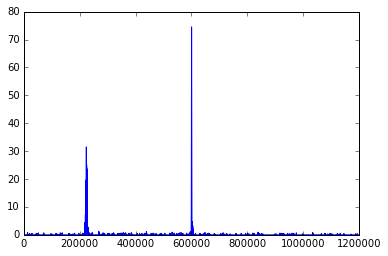

pmt_sum. Return to continue


In [357]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=8, plot=True)

In [363]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

In [364]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 102 sum in pes =3699.64199577


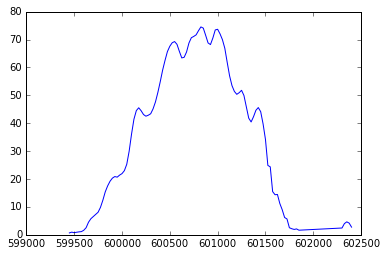

hit return


In [366]:
scan_S12(S2)

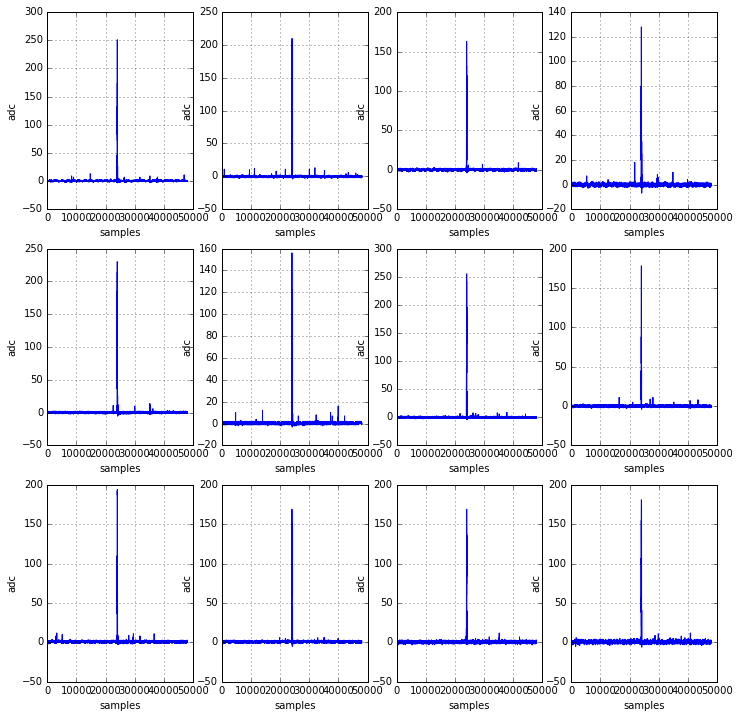

corrected waveform. Return to continue


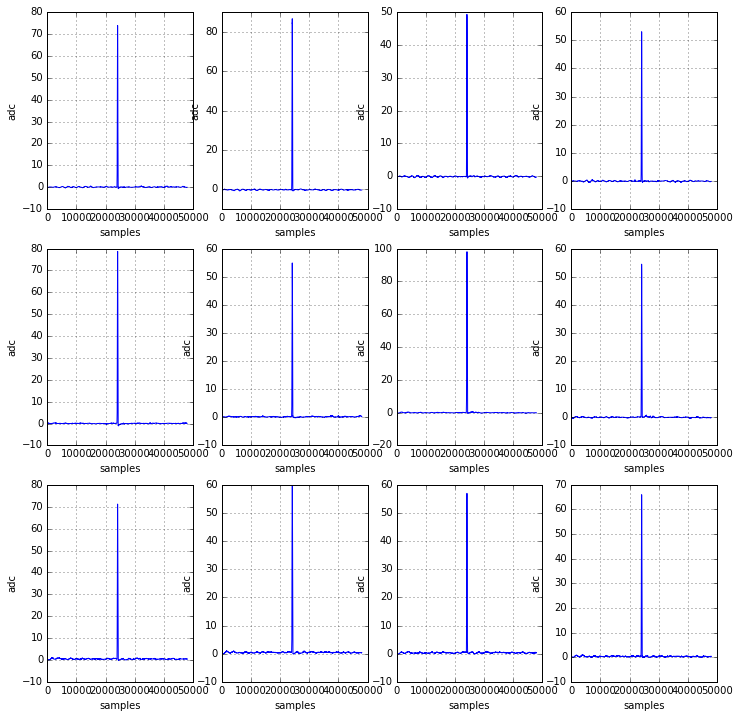

MAU. Return to continue


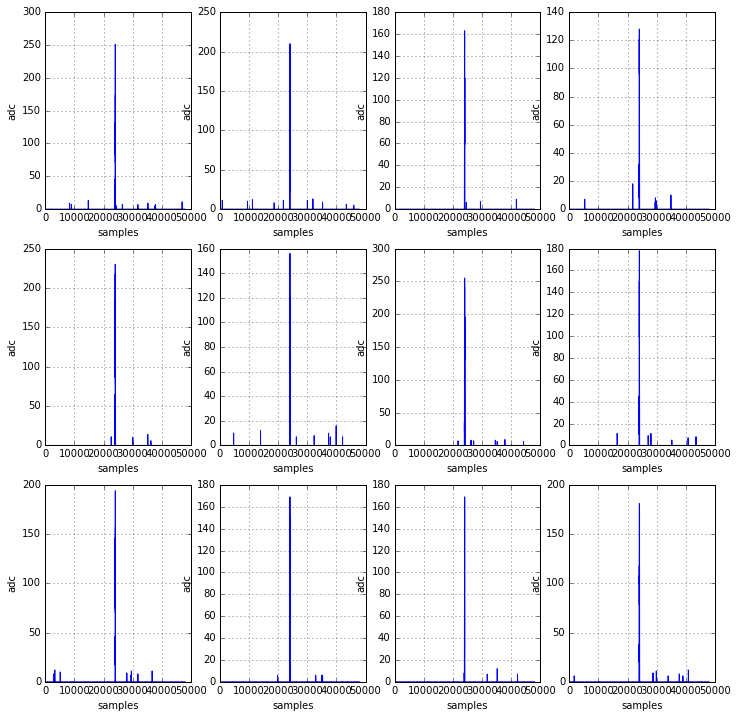

pmt_thr. Return to continue


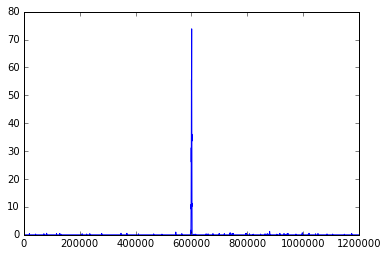

pmt_sum. Return to continue


In [367]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=9, plot=True)

In [368]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

number of peaks = 1
S12 number = 0, samples = 191 sum in pes =5902.55447401


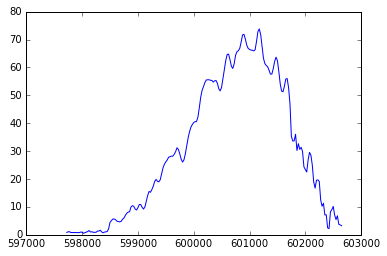

hit return


In [369]:
scan_S12(S2)

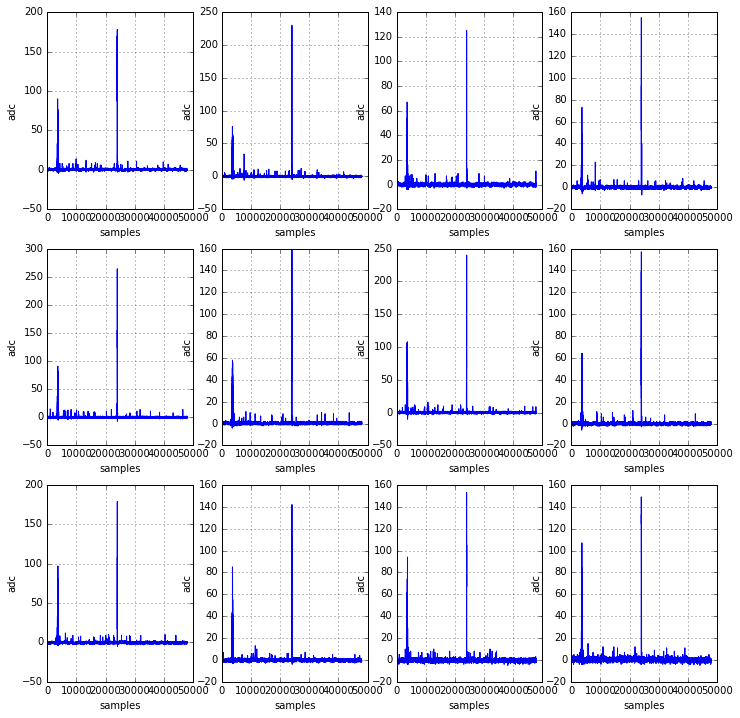

corrected waveform. Return to continue


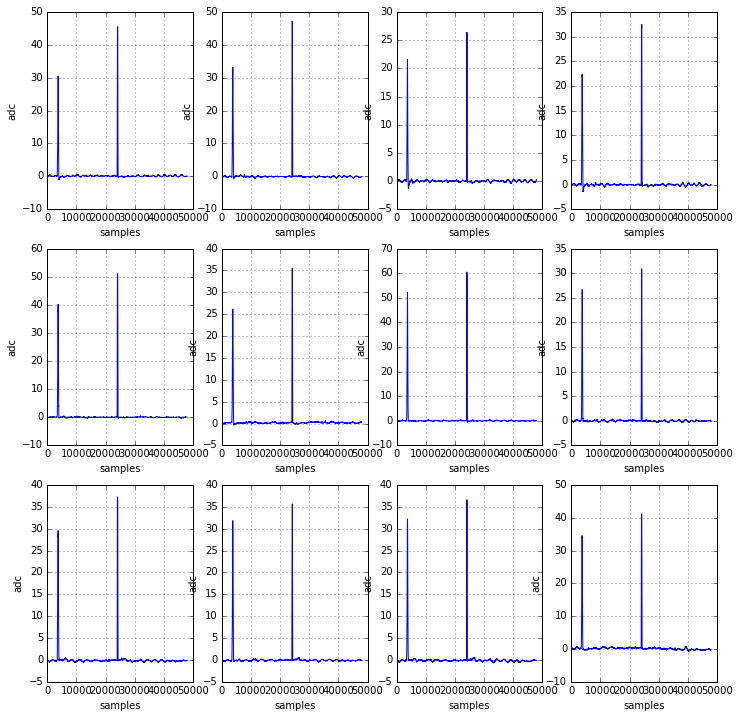

MAU. Return to continue


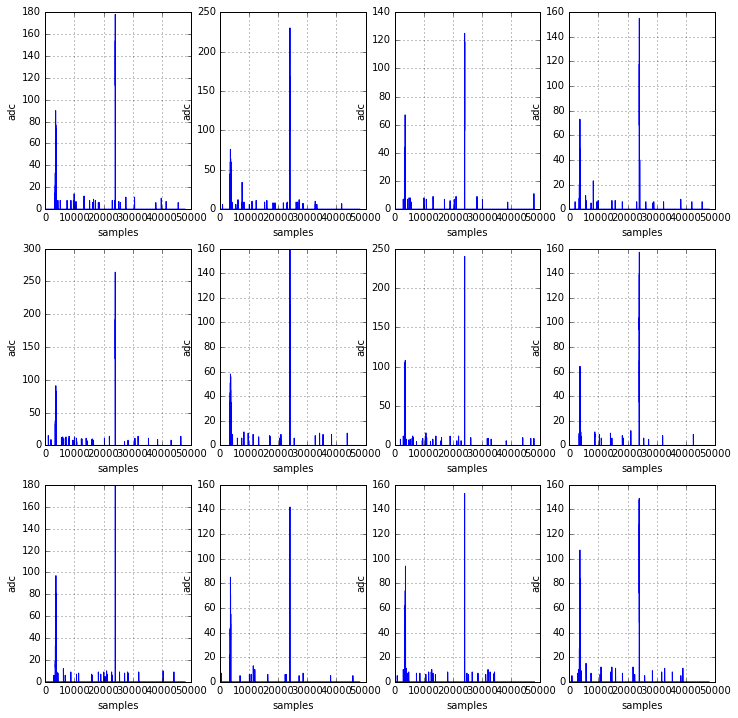

pmt_thr. Return to continue


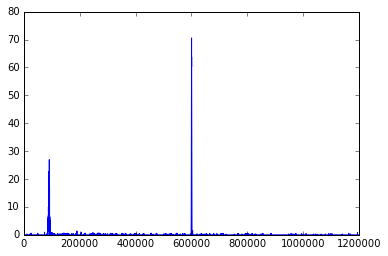

pmt_sum. Return to continue


In [370]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=10, plot=True)

In [371]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

number of peaks = 1
S12 number = 0, samples = 105 sum in pes =3704.23118758


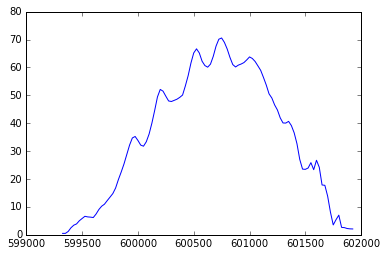

hit return


In [372]:
scan_S12(S2)

In [375]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=11, plot=False)

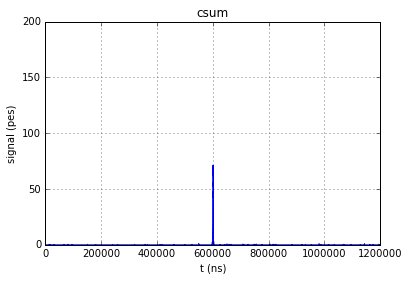

In [377]:
plot_signal(signal_t, csum, title="csum",
                signal_start=0, signal_end=1.2*units.ms, ymax = 200, units="pes")

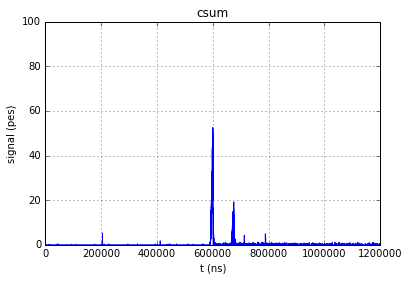

In [380]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=13, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

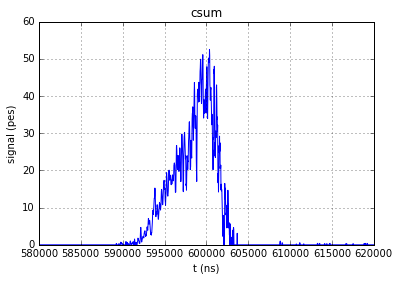

In [394]:
plot_signal(signal_t, csum, title="csum",
            signal_start=580*units.mus, signal_end=620*units.mus, ymax = 60, units="pes")

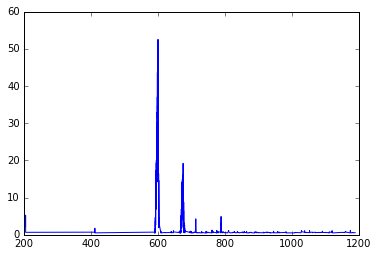

In [395]:
plt.plot(wfzs.time_ns.values/units.mus, wfzs.ene_pes)

In [381]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [382]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 9 sum in pes =23.5271837526


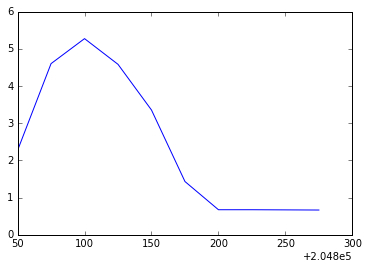

hit return


In [383]:
scan_S12(S1)

In [403]:
S2 = find_S12(wfzs, tmin=580*units.mus, tmax=620*units.mus, stride=80, lmin=50, lmax=550)

In [404]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 469 sum in pes =9017.89514076


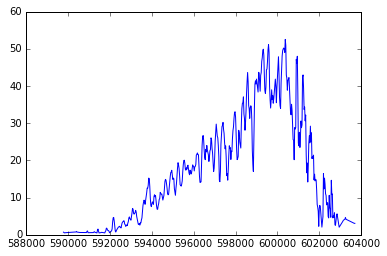

hit return


In [405]:
scan_S12(S2)

#### Not a kripton

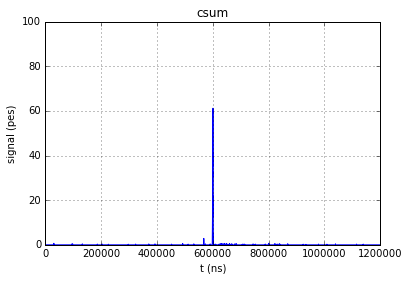

In [407]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=15, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

In [408]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)

In [409]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 9 sum in pes =14.8669160846


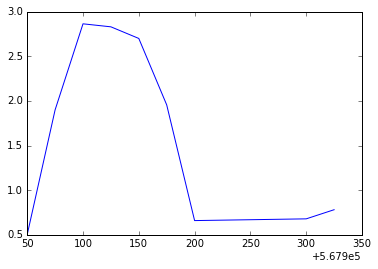

hit return


In [410]:
scan_S12(S1)

In [411]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

In [412]:
len(S2)

1

number of peaks = 1
S12 number = 0, samples = 161 sum in pes =4281.66296698


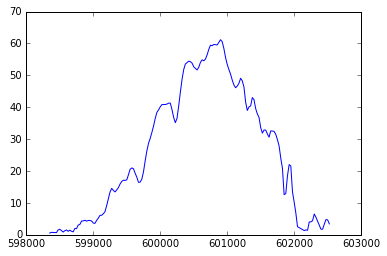

hit return


In [413]:
scan_S12(S2)

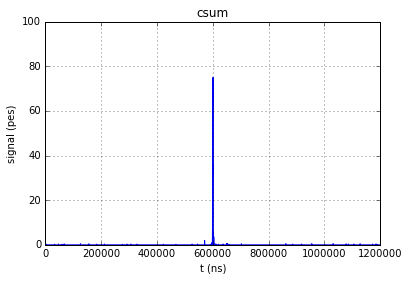

In [414]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=16, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

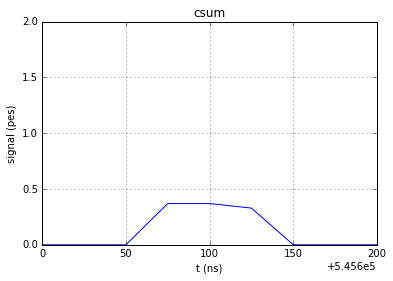

In [430]:
plot_signal(signal_t, csum, title="csum",
            signal_start=545600*units.ns, signal_end=545800*units.ns, ymax = 2, units="pes")

In [433]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=3, lmax=20)

In [434]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 4 sum in pes =5.74906401159


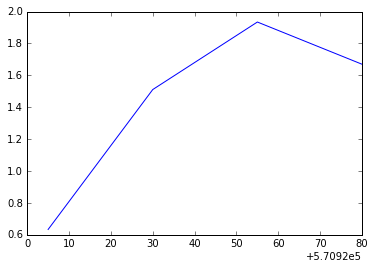

hit return


In [436]:
scan_S12(S1)

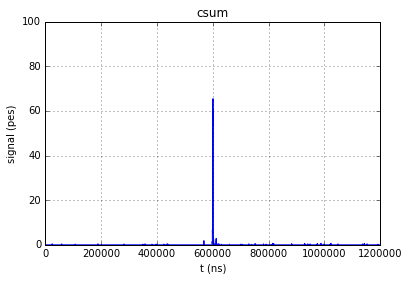

In [441]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=18, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

In [442]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)

In [443]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 9 sum in pes =12.0002803739


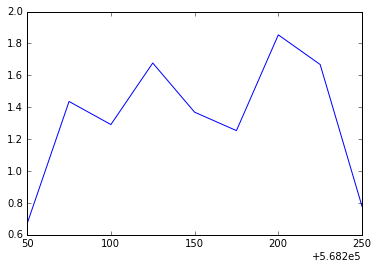

hit return


In [444]:
scan_S12(S1)

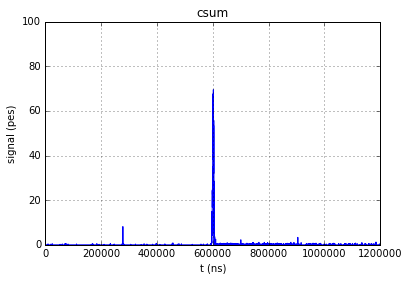

In [445]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=19, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

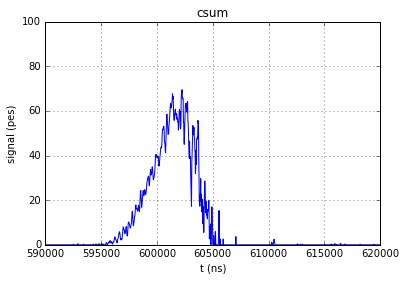

In [450]:
plot_signal(signal_t, csum, title="csum",
            signal_start=590*units.mus, signal_end=620*units.mus, ymax = 100, units="pes")

In [446]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)

number of peaks = 1
S12 number = 0, samples = 11 sum in pes =48.5730068261


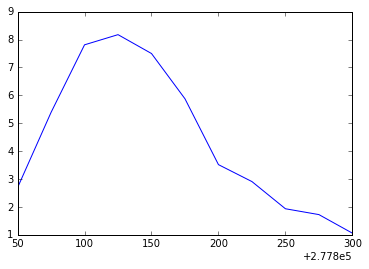

hit return


In [447]:
scan_S12(S1)

In [451]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=2500)

number of peaks = 1
S12 number = 0, samples = 389 sum in pes =11092.5826536


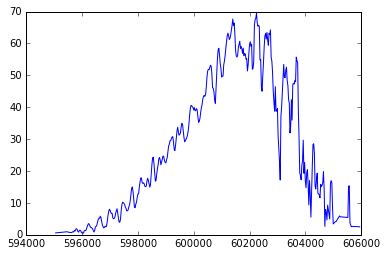

hit return


In [452]:
scan_S12(S2)

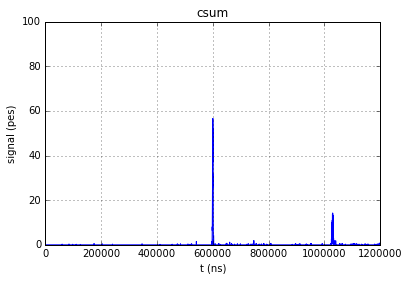

In [454]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=21, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

In [455]:
S1 = find_S12(wfzs, tmin=100*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)

In [456]:
len(S1)

1

number of peaks = 1
S12 number = 0, samples = 5 sum in pes =6.14772383057


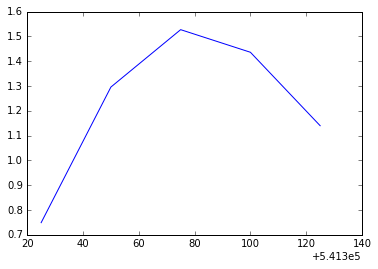

hit return


In [457]:
scan_S12(S1)

In [458]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)

number of peaks = 1
S12 number = 0, samples = 200 sum in pes =4707.90959305


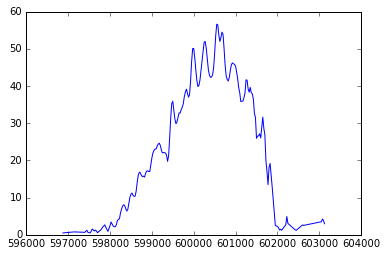

hit return


In [459]:
scan_S12(S2)

#### lowering the threshold on S1 to 4 samples, I start to find S1s that make sense

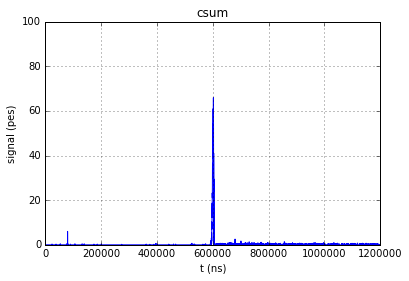

In [460]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=22, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

In [463]:
S1 = find_S12(wfzs, tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)

number of peaks = 1
S12 number = 0, samples = 11 sum in pes =32.2843473289


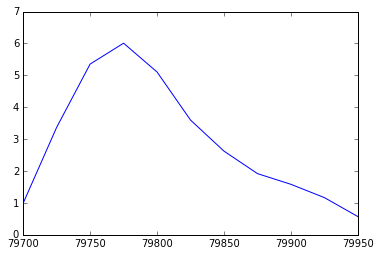

hit return


In [464]:
scan_S12(S1)

In [465]:
600e+3 - 79800

520200.0

#### Chamber is 570 mus long, cutoff must be at 30 mus

In [468]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=2500)

number of peaks = 1
S12 number = 0, samples = 439 sum in pes =10445.8180858


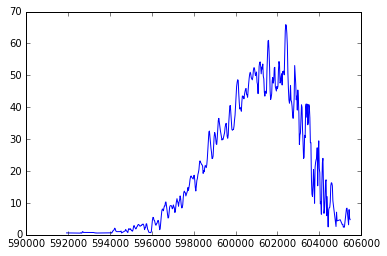

hit return


In [469]:
scan_S12(S2)

#### not a Kr!

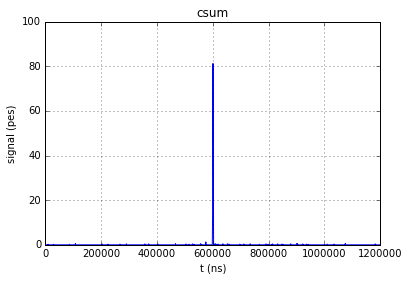

In [470]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=23, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

In [471]:
S1 = find_S12(wfzs, tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)

number of peaks = 1
S12 number = 0, samples = 6 sum in pes =5.370347586


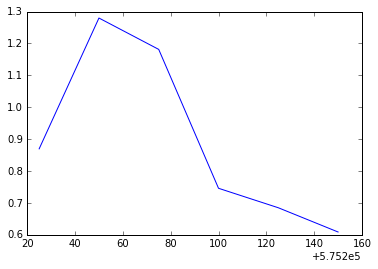

hit return


In [472]:
scan_S12(S1)

In [473]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=2500)

number of peaks = 1
S12 number = 0, samples = 148 sum in pes =5887.29418094


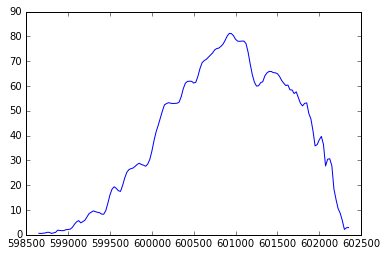

hit return


In [474]:
scan_S12(S2)

In [475]:
S1[0].describe()

,time_ns,ene_pes
count,6.000000,6.000000
mean,575287.500000,0.895058
std,46.770717,0.275373
min,575225.000000,0.608763
25%,575256.250000,0.700093
50%,575287.500000,0.807729
75%,575318.750000,1.103468
max,575350.000000,1.279864


In [480]:
(S2[0].time_ns.max() - S1[0].time_ns.max())/units.mus

27.0

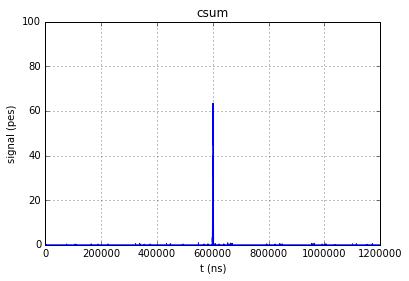

In [481]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=24, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

In [482]:
S1 = find_S12(wfzs, tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)

number of peaks = 1
S12 number = 0, samples = 5 sum in pes =3.68711878691


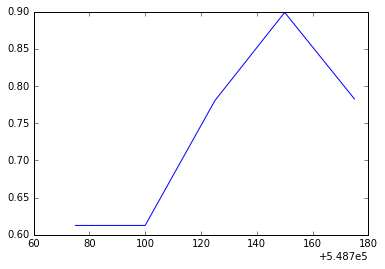

hit return


In [483]:
scan_S12(S1)

In [484]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=200)

number of peaks = 1
S12 number = 0, samples = 191 sum in pes =5437.62519267


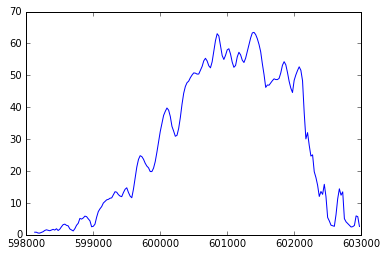

hit return


In [485]:
scan_S12(S2)

In [488]:
def time_S12(S1,S2):
    return (S2.time_ns.max() - S1.time_ns.max())/units.mus

In [489]:
time_S12(S1[0], S2[0])

54.100000000000001

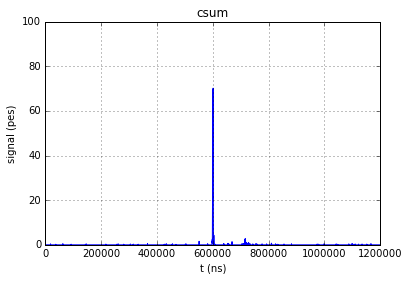

In [490]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=25, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 1
S12 number = 0, samples = 5 sum in pes =5.94802751525


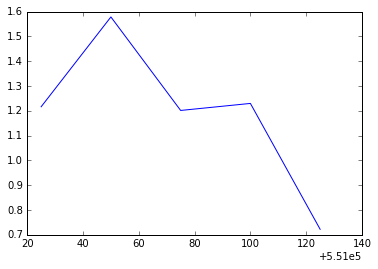

hit return


In [491]:
S1 = find_S12(wfzs, tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)
scan_S12(S1)

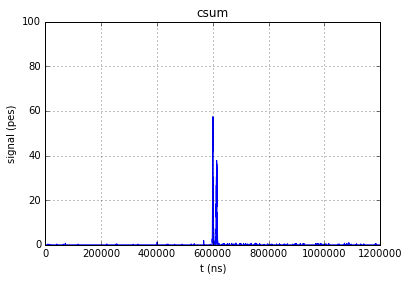

In [492]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=26, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 2
S12 number = 0, samples = 6 sum in pes =5.18114820352


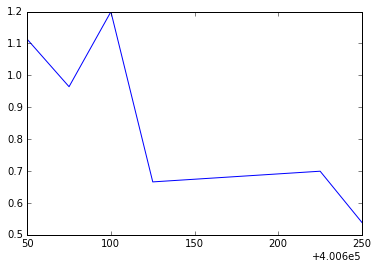

hit return
S12 number = 1, samples = 7 sum in pes =7.64674915636


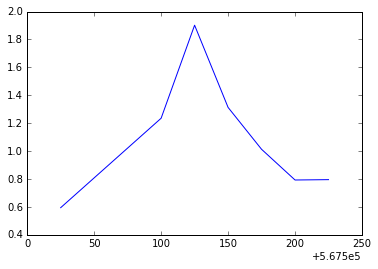

hit return


In [493]:
S1 = find_S12(wfzs, tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)
scan_S12(S1)

In [494]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=200)
scan_S12(S2)

number of peaks = 0


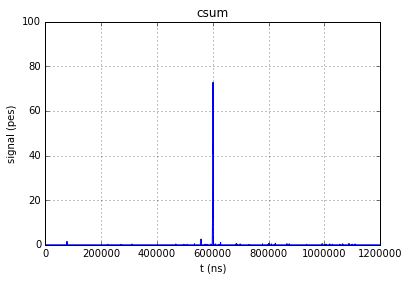

In [503]:
csum, wfzs = kriptonize(pmtcwf, MAU, adc_to_pes, 
             thr_MAU=5*units.adc, thr_s12=0.5*units.pes, 
             event=29, plot=False)
plot_signal(signal_t, csum, title="csum",
            signal_start=0, signal_end=1.2*units.ms, ymax = 100, units="pes")

number of peaks = 2
S12 number = 0, samples = 5 sum in pes =5.45118709736


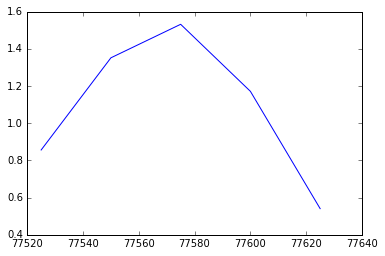

hit return
S12 number = 1, samples = 5 sum in pes =8.8638301246


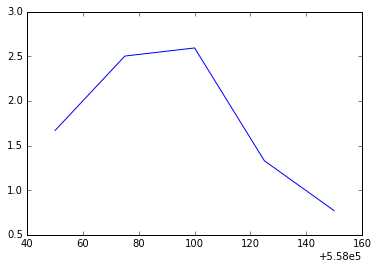

hit return


In [504]:
S1 = find_S12(wfzs, tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=20)
scan_S12(S1)

number of peaks = 1
S12 number = 0, samples = 171 sum in pes =5716.62015973


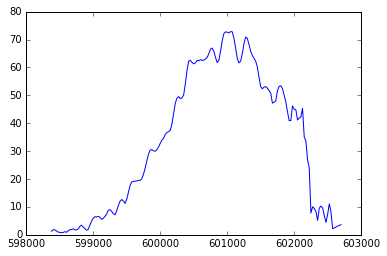

hit return


In [505]:
S2 = find_S12(wfzs, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=90, lmax=250)
scan_S12(S2)
